## Project Description


Our group is aimed to use supervised learning to train a 4-class image classifier that takes chest X-ray images as inputs and use image processing techniques that enhances the structure of the lung to put into our Convolutional Neural Network (CNN) model that classified the chest X-rays into four categories: normal, COVID pneumonia, viral pneumonia, and bacteria pneumonia. With this classifier, our goal is to classify 300 chest X-ray images within 15 minutes (15 times faster than manually classified by radiologists) with an accuracy of higher than 90%.

## Data Processing


In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**No Data Processing**

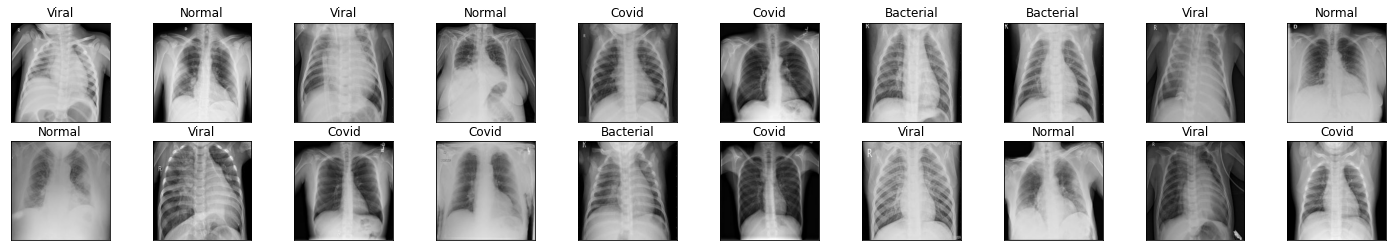

In [ ]:
# path where store the data
train_path= "/content/gdrive/My Drive/360 Project/ct_divide_resize/Train"
val_path= "/content/gdrive/My Drive/360 Project/ct_divide_resize/Validation"
test_path= "/content/gdrive/My Drive/360 Project/ct_divide_resize/Test"

# set fix size
transform = transforms.Compose(
        [transforms.Resize((224,224)), transforms.ToTensor()])

batch_size=32
train_data = torchvision.datasets.ImageFolder(root=train_path,transform=transform)
val_data = torchvision.datasets.ImageFolder(root=val_path,transform=transform)
test_data = torchvision.datasets.ImageFolder(root=test_path,transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                          num_workers=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=1, shuffle=True)


# Visualize some sample data
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
classes = ['Viral', 'Normal', 'Covid', 'Bacterial']

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [ ]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

11202
1385
1385


**Data Processed with Gamma Correction and Histogram
Equalization**

In [ ]:
# path where store the data
train_path= "/content/gdrive/My Drive/360 Project/ct_gamma_hist/Train"
val_path= "/content/gdrive/My Drive/360 Project/ct_gamma_hist/Validation"
test_path= "/content/gdrive/My Drive/360 Project/ct_gamma_hist/Test"

# set fix size
transform = transforms.Compose(
            [transforms.Resize((224,224)), transforms.ToTensor(), 
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 1

train_data = torchvision.datasets.ImageFolder(root=train_path,transform=transform)
val_data = torchvision.datasets.ImageFolder(root=val_path,transform=transform)
test_data = torchvision.datasets.ImageFolder(root=test_path,transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                          num_workers=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=1, shuffle=True)

classes = ['Viral', 'Normal', 'Covid', 'Bacterial']

## Baseline Model

**Random Forests**

Only used 1/3 of the training set due to memory shortage.
Train data: 3734

In [ ]:
import torchvision.models
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics

In [ ]:
train_path= "/content/gdrive/My Drive/360 Project/ct_gamma_hist/Train"
val_path= "/content/gdrive/My Drive/360 Project/ct_gamma_hist/Validation"
test_path= "/content/gdrive/My Drive/360 Project/ct_gamma_hist/Test"

# set fix size
transform = transforms.Compose(
            [transforms.Resize((224,224)), transforms.ToTensor(), 
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = torchvision.datasets.ImageFolder(root=train_path,transform=transform)
val_data = torchvision.datasets.ImageFolder(root=val_path,transform=transform)
test_data = torchvision.datasets.ImageFolder(root=test_path,transform=transform)

train_sub = list(range(0, len(train_data), 3))

train_set = torch.utils.data.Subset(train_data, train_sub)

batch_size = 1

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                           num_workers=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                          num_workers=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=1, shuffle=True)

classes = ['Viral', 'Normal', 'Covid', 'Bacterial']

In [ ]:
Train_X = []
Train_y = []
for x, y in train_loader:
  Train_X.append(x)
  Train_y.append(y)

Train_X = torch.stack(Train_X)
Train_y = torch.stack(Train_y)
Train_X = Train_X.reshape(Train_X.shape[0], 224*224*3)

In [ ]:
Valid_X = []
Valid_y = []
for x, y in val_loader:
  Valid_X.append(x)
  Valid_y.append(y)

Valid_X = torch.stack(Valid_X)
Valid_y = torch.stack(Valid_y)
Valid_X = Valid_X.reshape(Valid_X.shape[0], 224*224*3)

In [ ]:
Test_X = []
Test_y = []
for x, y in test_loader:
  Test_X.append(x)
  Test_y.append(y)

Test_X = torch.stack(Test_X)
Test_y = torch.stack(Test_y)
Test_X = Test_X.reshape(Test_X.shape[0], 224*224*3)

In [ ]:
# Number of Trees: 200
model = RandomForestClassifier(n_estimators = 200, criterion = 'entropy', random_state = 20)
model.fit(Train_X,Train_y.ravel())
train_pred = model.predict(Train_X)
train_acc = accuracy_score(Train_y,train_pred)
val_pred = model.predict(Valid_X)
val_acc = accuracy_score(Valid_y,val_pred)
test_pred = model.predict(Test_X)
test_acc = accuracy_score(Test_y,test_pred)

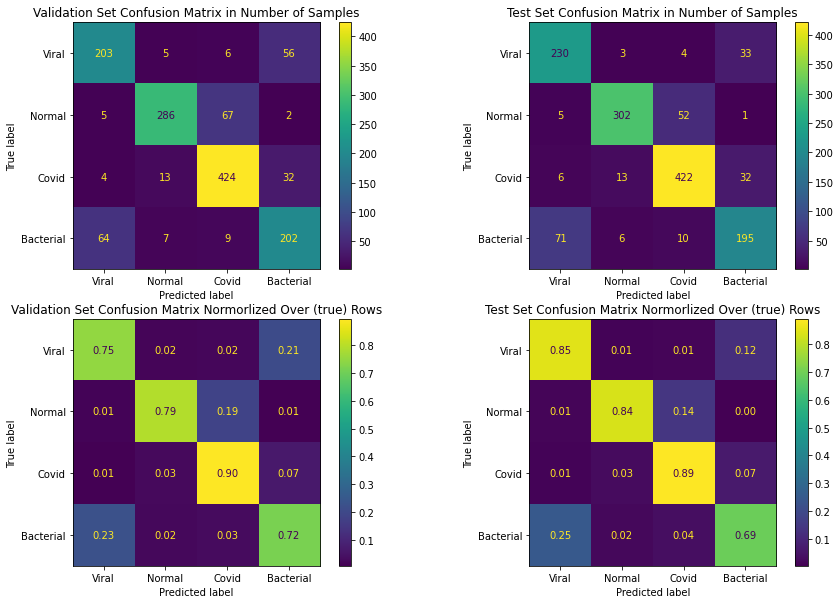

1.0
0.8050541516245487
0.8296028880866426


In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
ax = axes.flatten()

disp = metrics.plot_confusion_matrix(model, Valid_X, Valid_y, display_labels=classes,values_format='g',ax=ax[0])
disp.ax_.set_title("Validation Set Confusion Matrix in Number of Samples")

disp = metrics.plot_confusion_matrix(model, Test_X, Test_y, display_labels=classes,values_format='g',ax=ax[1])
disp.ax_.set_title("Test Set Confusion Matrix in Number of Samples")

disp = metrics.plot_confusion_matrix(model, Valid_X, Valid_y, display_labels=classes,values_format='.2f',ax=ax[2],normalize='true')
disp.ax_.set_title("Validation Set Confusion Matrix Normorlized Over (true) Rows")

disp = metrics.plot_confusion_matrix(model, Test_X, Test_y, display_labels=classes,values_format='.2f',ax=ax[3],normalize='true')
disp.ax_.set_title("Test Set Confusion Matrix Normorlized Over (true) Rows")

plt.show()

print(train_acc)
print(val_acc)
print(test_acc)

In [ ]:
# Number of Trees: 100
model = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 20)
model.fit(Train_X,Train_y.ravel())
train_pred = model.predict(Train_X)
train_acc = accuracy_score(Train_y,train_pred)
val_pred = model.predict(Valid_X)
val_acc = accuracy_score(Valid_y,val_pred)
test_pred = model.predict(Test_X)
test_acc = accuracy_score(Test_y,test_pred)

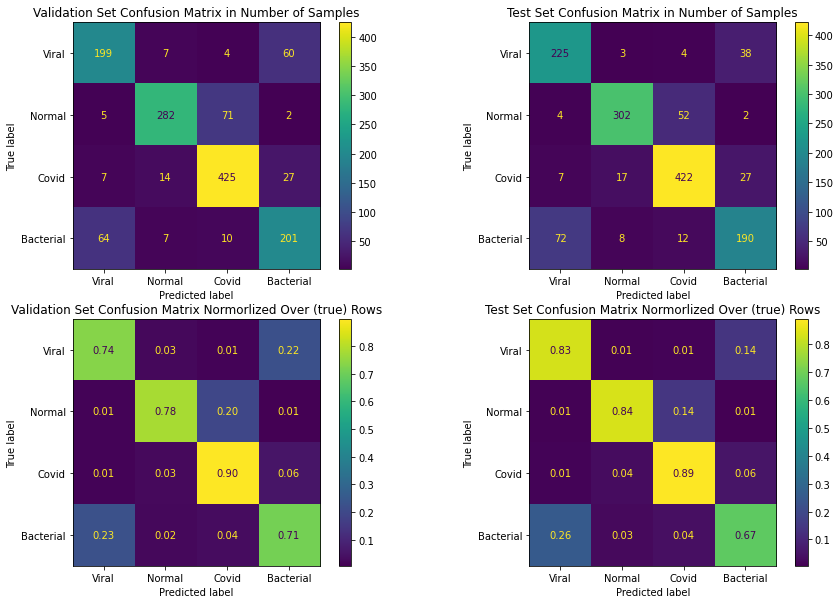

1.0
0.7992779783393502
0.8223826714801444


In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
ax = axes.flatten()

disp = metrics.plot_confusion_matrix(model, Valid_X, Valid_y, display_labels=classes,values_format='g',ax=ax[0])
disp.ax_.set_title("Validation Set Confusion Matrix in Number of Samples")

disp = metrics.plot_confusion_matrix(model, Test_X, Test_y, display_labels=classes,values_format='g',ax=ax[1])
disp.ax_.set_title("Test Set Confusion Matrix in Number of Samples")

disp = metrics.plot_confusion_matrix(model, Valid_X, Valid_y, display_labels=classes,values_format='.2f',ax=ax[2],normalize='true')
disp.ax_.set_title("Validation Set Confusion Matrix Normorlized Over (true) Rows")

disp = metrics.plot_confusion_matrix(model, Test_X, Test_y, display_labels=classes,values_format='.2f',ax=ax[3],normalize='true')
disp.ax_.set_title("Test Set Confusion Matrix Normorlized Over (true) Rows")

plt.show()

print(train_acc)
print(val_acc)
print(test_acc)

In [ ]:
# Number of Trees: 50
model = RandomForestClassifier(n_estimators = 50, criterion = 'entropy', random_state = 20)
model.fit(Train_X,Train_y.ravel())
train_pred = model.predict(Train_X)
train_acc = accuracy_score(Train_y,train_pred)
val_pred = model.predict(Valid_X)
val_acc = accuracy_score(Valid_y,val_pred)
test_pred = model.predict(Test_X)
test_acc = accuracy_score(Test_y,test_pred)

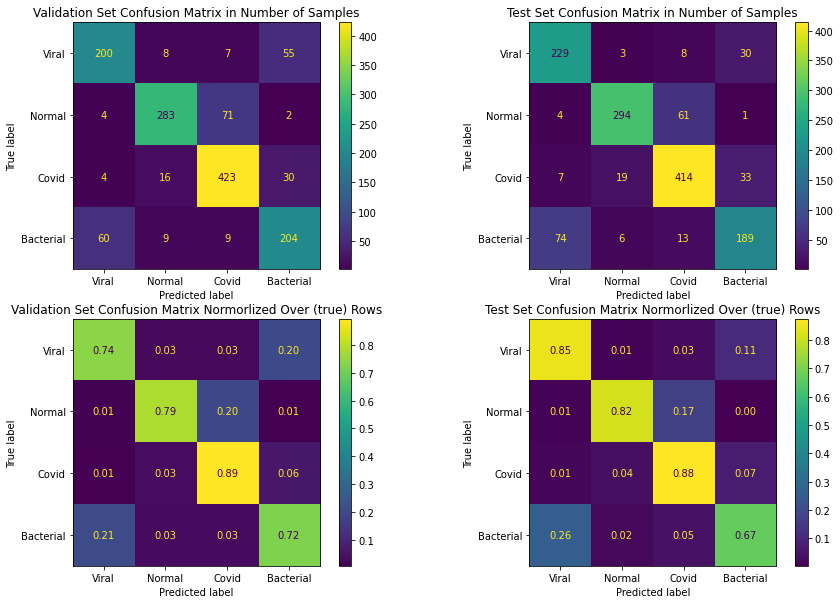

1.0
0.8014440433212996
0.8129963898916968


In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
ax = axes.flatten()

disp = metrics.plot_confusion_matrix(model, Valid_X, Valid_y, display_labels=classes,values_format='g',ax=ax[0])
disp.ax_.set_title("Validation Set Confusion Matrix in Number of Samples")

disp = metrics.plot_confusion_matrix(model, Test_X, Test_y, display_labels=classes,values_format='g',ax=ax[1])
disp.ax_.set_title("Test Set Confusion Matrix in Number of Samples")

disp = metrics.plot_confusion_matrix(model, Valid_X, Valid_y, display_labels=classes,values_format='.2f',ax=ax[2],normalize='true')
disp.ax_.set_title("Validation Set Confusion Matrix Normorlized Over (true) Rows")

disp = metrics.plot_confusion_matrix(model, Test_X, Test_y, display_labels=classes,values_format='.2f',ax=ax[3],normalize='true')
disp.ax_.set_title("Test Set Confusion Matrix Normorlized Over (true) Rows")

plt.show()

print(train_acc)
print(val_acc)
print(test_acc)

In [ ]:
# Number of Trees: 20
model = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', random_state = 20)
model.fit(Train_X,Train_y.ravel())
train_pred = model.predict(Train_X)
train_acc = accuracy_score(Train_y,train_pred)
val_pred = model.predict(Valid_X)
val_acc = accuracy_score(Valid_y,val_pred)
test_pred = model.predict(Test_X)
test_acc = accuracy_score(Test_y,test_pred)

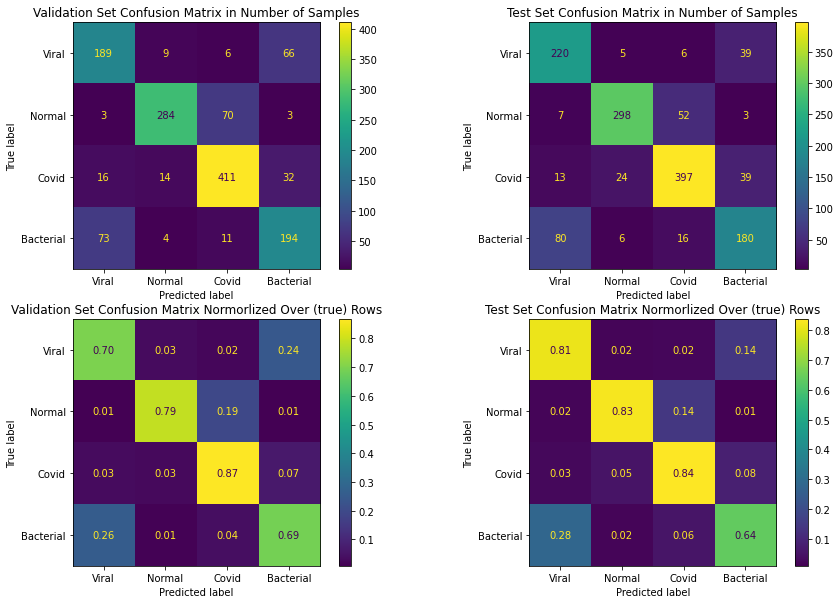

1.0
0.7783393501805054
0.7906137184115524


In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
ax = axes.flatten()

disp = metrics.plot_confusion_matrix(model, Valid_X, Valid_y, display_labels=classes,values_format='g',ax=ax[0])
disp.ax_.set_title("Validation Set Confusion Matrix in Number of Samples")

disp = metrics.plot_confusion_matrix(model, Test_X, Test_y, display_labels=classes,values_format='g',ax=ax[1])
disp.ax_.set_title("Test Set Confusion Matrix in Number of Samples")

disp = metrics.plot_confusion_matrix(model, Valid_X, Valid_y, display_labels=classes,values_format='.2f',ax=ax[2],normalize='true')
disp.ax_.set_title("Validation Set Confusion Matrix Normorlized Over (true) Rows")

disp = metrics.plot_confusion_matrix(model, Test_X, Test_y, display_labels=classes,values_format='.2f',ax=ax[3],normalize='true')
disp.ax_.set_title("Test Set Confusion Matrix Normorlized Over (true) Rows")

plt.show()

print(train_acc)
print(val_acc)
print(test_acc)

SVM:

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score
import time

Train with 1/10 training data:

In [ ]:
train_path= "/content/gdrive/My Drive/360 Project/ct_gamma_hist/Train"
val_path= "/content/gdrive/My Drive/360 Project/ct_gamma_hist/Validation"
test_path= "/content/gdrive/My Drive/360 Project/ct_gamma_hist/Test"

# set fix size
transform = transforms.Compose(
            [transforms.Resize((224,224)), transforms.ToTensor(), 
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = torchvision.datasets.ImageFolder(root=train_path,transform=transform)
val_data = torchvision.datasets.ImageFolder(root=val_path,transform=transform)
test_data = torchvision.datasets.ImageFolder(root=test_path,transform=transform)

train_sub = list(range(0, len(train_data), 10))

train_set = torch.utils.data.Subset(train_data, train_sub)

batch_size = 1

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                           num_workers=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                          num_workers=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=1, shuffle=True)

classes = ['Viral', 'Normal', 'Covid', 'Bacterial']

In [ ]:
train_data_SVC = []
train_label_SVC = []
for x, y in train_loader:
  train_data_SVC.append(x)
  train_label_SVC.append(y)

train_data_SVC = torch.stack(train_data_SVC)
train_label_SVC = torch.stack(train_label_SVC)
train_data_SVC = train_data_SVC.reshape(train_data_SVC.shape[0], 224*224*3)

In [ ]:
print(train_data_SVC.shape)
print(train_label_SVC.shape)

torch.Size([1121, 150528])
torch.Size([1121, 1])


But validate on all validation data:

In [ ]:
val_data_SVC_full = []
val_label_SVC_full = []
val_loader = torch.utils.data.DataLoader(val_data, batch_size=1, 
                                          num_workers=1, shuffle=True)
for x, y in val_loader:
  val_data_SVC_full.append(x)
  val_label_SVC_full.append(y)

val_data_SVC_full = torch.stack(val_data_SVC_full)
val_label_SVC_full = torch.stack(val_label_SVC_full)
val_data_SVC_full = val_data_SVC_full.reshape(val_data_SVC_full.shape[0], 224*224*3)

In [ ]:
test_data_SVC = []
test_label_SVC = []
for x, y in test_loader:
  test_data_SVC.append(x)
  test_label_SVC.append(y)

test_data_SVC = torch.stack(test_data_SVC)
test_label_SVC = torch.stack(test_label_SVC)
test_data_SVC = test_data_SVC.reshape(test_data_SVC.shape[0], 224*224*3)


In [ ]:
svc_linear = SVC(kernel='linear')
svc_linear.fit(train_data_SVC, train_label_SVC.ravel()) 

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

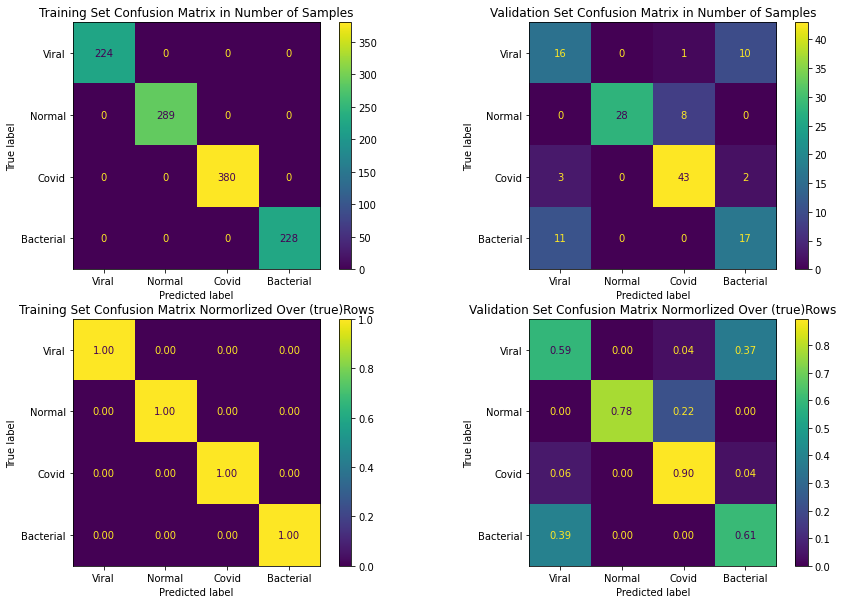

Train Accuracy: 1.0
Validation Accuracy: 0.7482014388489209
Test Accuracy: 0.31654676258992803


In [ ]:
train_acc = svc_linear.score(train_data_SVC, train_label_SVC)
test_acc = svc_linear.score(test_data_SVC, test_label_SVC)
val_acc = svc_linear.score(val_data_SVC, val_label_SVC)

from sklearn import metrics
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
ax = axes.flatten()

disp = metrics.plot_confusion_matrix(svc_linear, train_data_SVC, train_label_SVC, display_labels=classes,values_format='g',ax=ax[0])
disp.ax_.set_title("Training Set Confusion Matrix in Number of Samples")

disp = metrics.plot_confusion_matrix(svc_linear, val_data_SVC, val_label_SVC, display_labels=classes,values_format='g',ax=ax[1])
disp.ax_.set_title("Validation Set Confusion Matrix in Number of Samples")

disp = metrics.plot_confusion_matrix(svc_linear, train_data_SVC, train_label_SVC, display_labels=classes,values_format='.2f',ax=ax[2],normalize='true')
disp.ax_.set_title("Training Set Confusion Matrix Normorlized Over (true)Rows")

disp = metrics.plot_confusion_matrix(svc_linear, val_data_SVC, val_label_SVC, display_labels=classes,values_format='.2f',ax=ax[3],normalize='true')
disp.ax_.set_title("Validation Set Confusion Matrix Normorlized Over (true)Rows")

plt.show()

print("Train Accuracy:", train_acc)
print("Validation Accuracy:", val_acc)
print("Test Accuracy:", test_acc)

In [ ]:
svc_rbf = SVC(kernel='rbf')
svc_rbf.fit(train_data_SVC, train_label_SVC.ravel()) 

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Total time elapsed for predicting: 331.74 seconds for 1385 images.


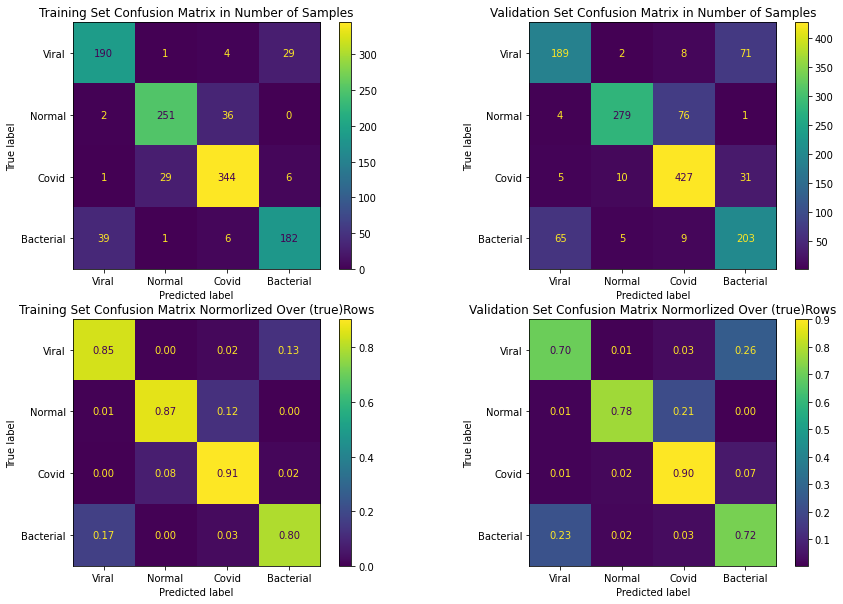

Train Accuracy: 0.8626226583407671
Validation Accuracy: 0.7927797833935019
Test Accuracy: 0.7935018050541516
F1 score on Validation set: 0.793650181195986


In [ ]:
train_acc = svc_rbf.score(train_data_SVC, train_label_SVC)
test_acc = svc_rbf.score(test_data_SVC, test_label_SVC)
val_acc = svc_rbf.score(val_data_SVC_full, val_label_SVC_full)

start_time = time.time()
val_pred = svc_rbf.predict(val_data_SVC_full)
end_time = time.time()
elapsed_time = end_time - start_time
print("Total time elapsed for predicting: {:.2f} seconds for {:d} images.".format(elapsed_time, 1385))

from sklearn import metrics
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
ax = axes.flatten()

disp = metrics.plot_confusion_matrix(svc_rbf, train_data_SVC, train_label_SVC, display_labels=classes,values_format='g',ax=ax[0])
disp.ax_.set_title("Training Set Confusion Matrix in Number of Samples")

disp = metrics.plot_confusion_matrix(svc_rbf, val_data_SVC_full, val_label_SVC_full, display_labels=classes,values_format='g',ax=ax[1])
disp.ax_.set_title("Validation Set Confusion Matrix in Number of Samples")

disp = metrics.plot_confusion_matrix(svc_rbf, train_data_SVC, train_label_SVC, display_labels=classes,values_format='.2f',ax=ax[2],normalize='true')
disp.ax_.set_title("Training Set Confusion Matrix Normorlized Over (true)Rows")

disp = metrics.plot_confusion_matrix(svc_rbf, val_data_SVC_full, val_label_SVC_full, display_labels=classes,values_format='.2f',ax=ax[3],normalize='true')
disp.ax_.set_title("Validation Set Confusion Matrix Normorlized Over (true)Rows")

plt.show()

print("Train Accuracy:", train_acc)
print("Validation Accuracy:", val_acc)
print("Test Accuracy:", test_acc)
print("F1 score on Validation set:", f1_score(val_label_SVC_full, val_pred, average='weighted'))

In [ ]:
from sklearn.externals import joblib
joblib.dump(svc_rbf,'/content/gdrive/MyDrive/360 Project/svc_rbc_1.model')

['/content/gdrive/MyDrive/360 Project/svc_rbc_1.model']

In [ ]:
svc_rbf = SVC(kernel='rbf')
svc_rbf.fit(train_data_SVC, train_label_SVC.ravel()) 

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Total time elapsed for predicting: 311.47 seconds for 1385 images.


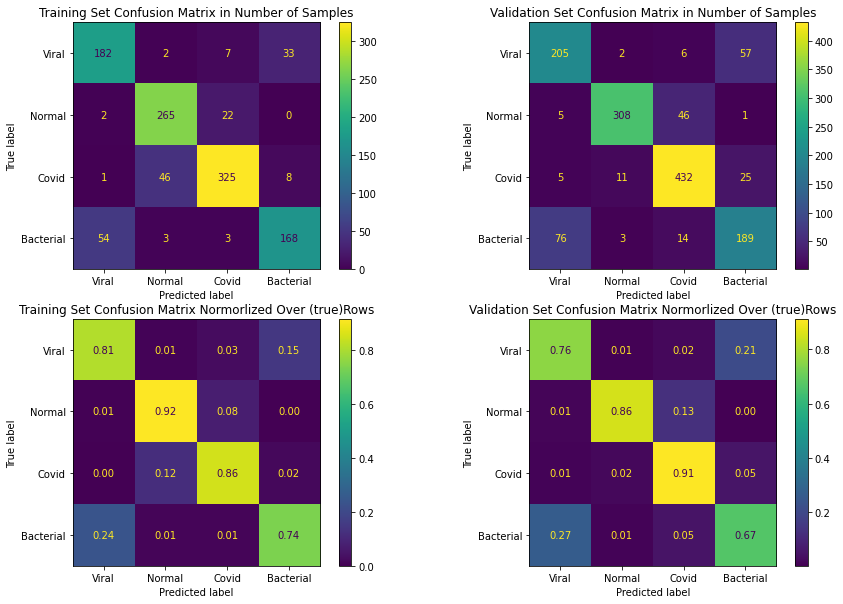

Train Accuracy: 0.8385370205173952
Validation Accuracy: 0.8187725631768953
Test Accuracy: 0.8057553956834532
F1 score on Validation set: 0.8193687565364224


In [ ]:
train_acc = svc_rbf.score(train_data_SVC, train_label_SVC)
test_acc = svc_rbf.score(test_data_SVC, test_label_SVC)
val_acc = svc_rbf.score(val_data_SVC_full, val_label_SVC_full)

start_time = time.time()
val_pred = svc_rbf.predict(val_data_SVC_full)
end_time = time.time()
elapsed_time = end_time - start_time
print("Total time elapsed for predicting: {:.2f} seconds for {:d} images.".format(elapsed_time, 1385))

from sklearn import metrics
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
ax = axes.flatten()

disp = metrics.plot_confusion_matrix(svc_rbf, train_data_SVC, train_label_SVC, display_labels=classes,values_format='g',ax=ax[0])
disp.ax_.set_title("Training Set Confusion Matrix in Number of Samples")

disp = metrics.plot_confusion_matrix(svc_rbf, val_data_SVC_full, val_label_SVC_full, display_labels=classes,values_format='g',ax=ax[1])
disp.ax_.set_title("Validation Set Confusion Matrix in Number of Samples")

disp = metrics.plot_confusion_matrix(svc_rbf, train_data_SVC, train_label_SVC, display_labels=classes,values_format='.2f',ax=ax[2],normalize='true')
disp.ax_.set_title("Training Set Confusion Matrix Normorlized Over (true)Rows")

disp = metrics.plot_confusion_matrix(svc_rbf, val_data_SVC_full, val_label_SVC_full, display_labels=classes,values_format='.2f',ax=ax[3],normalize='true')
disp.ax_.set_title("Validation Set Confusion Matrix Normorlized Over (true)Rows")

plt.show()

print("Train Accuracy:", train_acc)
print("Validation Accuracy:", val_acc)
print("Test Accuracy:", test_acc)
print("F1 score on Validation set:", f1_score(val_label_SVC_full, val_pred, average='weighted'))

Total time elapsed for predicting: 299.86 seconds for 1385 images.


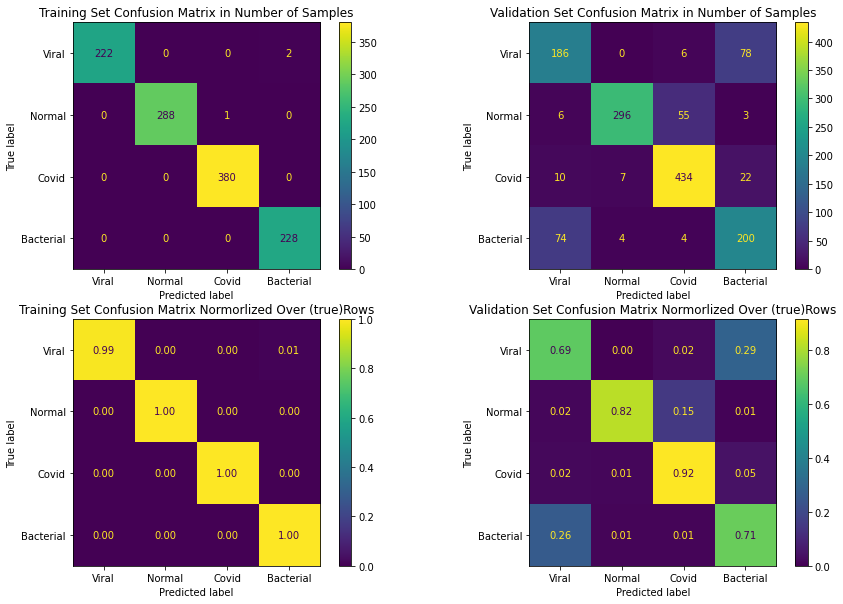

Train Accuracy: 0.9973238180196253
Validation Accuracy: 0.8057761732851986
F1 score on Validation set: 0.8077167820640248
Test Accuracy: 0.8273381294964028


In [ ]:
svc_rbf = SVC(kernel='rbf', C=10)
svc_rbf.fit(train_data_SVC, train_label_SVC.ravel()) 

start_time = time.time()
val_pred = svc_rbf.predict(val_data_SVC_full)
end_time = time.time()
elapsed_time = end_time - start_time
print("Total time elapsed for predicting: {:.2f} seconds for {:d} images.".format(elapsed_time, 1385))

train_acc = svc_rbf.score(train_data_SVC, train_label_SVC)
test_acc = svc_rbf.score(test_data_SVC, test_label_SVC)
val_acc = svc_rbf.score(val_data_SVC_full, val_label_SVC_full)

from sklearn import metrics
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
ax = axes.flatten()

disp = metrics.plot_confusion_matrix(svc_rbf, train_data_SVC, train_label_SVC, display_labels=classes,values_format='g',ax=ax[0])
disp.ax_.set_title("Training Set Confusion Matrix in Number of Samples")

disp = metrics.plot_confusion_matrix(svc_rbf, val_data_SVC_full, val_label_SVC_full, display_labels=classes,values_format='g',ax=ax[1])
disp.ax_.set_title("Validation Set Confusion Matrix in Number of Samples")

disp = metrics.plot_confusion_matrix(svc_rbf, train_data_SVC, train_label_SVC, display_labels=classes,values_format='.2f',ax=ax[2],normalize='true')
disp.ax_.set_title("Training Set Confusion Matrix Normorlized Over (true)Rows")

disp = metrics.plot_confusion_matrix(svc_rbf, val_data_SVC_full, val_label_SVC_full, display_labels=classes,values_format='.2f',ax=ax[3],normalize='true')
disp.ax_.set_title("Validation Set Confusion Matrix Normorlized Over (true)Rows")

plt.show()

print("Train Accuracy:", train_acc)
print("Validation Accuracy:", val_acc)
print("F1 score on Validation set:", f1_score(val_label_SVC_full, val_pred, average='weighted'))
print("Test Accuracy:", test_acc)

In [ ]:
def get_data_loader_normalize(batch_size):
    train_path= "/content/gdrive/My Drive/360 Project/ct_divide_resize/Train"
    val_path= "/content/gdrive/My Drive/360 Project/ct_divide_resize/Validation"
    test_path= "/content/gdrive/My Drive/360 Project/ct_divide_resize/Test"

    # set fix size
    transform = transforms.Compose(
            [transforms.Resize((224,224)), transforms.ToTensor(), 
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    train_data = torchvision.datasets.ImageFolder(root=train_path,transform=transform)
    val_data = torchvision.datasets.ImageFolder(root=val_path,transform=transform)
    test_data = torchvision.datasets.ImageFolder(root=test_path,transform=transform)
    train_sub = list(range(0, len(train_data), 10))
    val_sub = list(range(0, len(val_data), 10))
    test_sub = list(range(0, len(test_data), 10))
    train_set = torch.utils.data.Subset(train_data, train_sub)
    val_set = torch.utils.data.Subset(val_data, val_sub)
    test_set = torch.utils.data.Subset(test_data, test_sub)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                            num_workers=1, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, 
                                            num_workers=1, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, 
                                            num_workers=1, shuffle=True)

    classes = ['Viral', 'Normal', 'Covid', 'Bacterial']
    return train_loader, val_loader, test_loader, classes

In [ ]:
svc_poly = SVC(kernel='poly')
svc_poly.fit(train_data_SVC, train_label_SVC.ravel()) 

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Total time elapsed for predicting: 309.87 seconds for 1385 images.


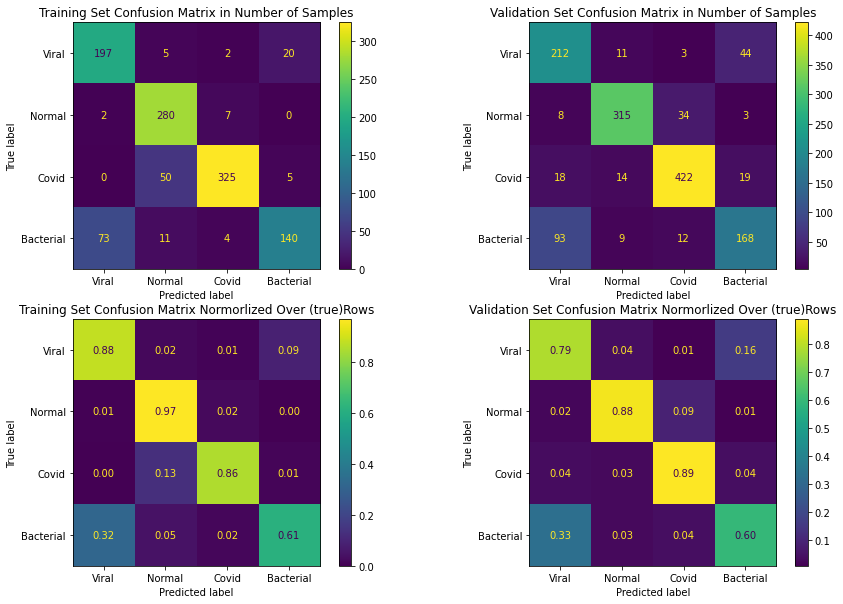

Train Accuracy: 0.840321141837645
Validation Accuracy: 0.8064981949458484
F1 score on Validation set: 0.8064199775542579
Test Accuracy: 0.7410071942446043


In [ ]:
start_time = time.time()
val_pred = svc_poly.predict(val_data_SVC_full)
end_time = time.time()
elapsed_time = end_time - start_time
print("Total time elapsed for predicting: {:.2f} seconds for {:d} images.".format(elapsed_time, 1385))

train_acc = svc_poly.score(train_data_SVC, train_label_SVC)
test_acc = svc_poly.score(test_data_SVC, test_label_SVC)
val_acc = svc_poly.score(val_data_SVC_full, val_label_SVC_full)

from sklearn import metrics
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
ax = axes.flatten()

disp = metrics.plot_confusion_matrix(svc_poly, train_data_SVC, train_label_SVC, display_labels=classes,values_format='g',ax=ax[0])
disp.ax_.set_title("Training Set Confusion Matrix in Number of Samples")

disp = metrics.plot_confusion_matrix(svc_poly, val_data_SVC_full, val_label_SVC_full, display_labels=classes,values_format='g',ax=ax[1])
disp.ax_.set_title("Validation Set Confusion Matrix in Number of Samples")

disp = metrics.plot_confusion_matrix(svc_poly, train_data_SVC, train_label_SVC, display_labels=classes,values_format='.2f',ax=ax[2],normalize='true')
disp.ax_.set_title("Training Set Confusion Matrix Normorlized Over (true)Rows")

disp = metrics.plot_confusion_matrix(svc_poly, val_data_SVC_full, val_label_SVC_full, display_labels=classes,values_format='.2f',ax=ax[3],normalize='true')
disp.ax_.set_title("Validation Set Confusion Matrix Normorlized Over (true)Rows")

plt.show()

print("Train Accuracy:", train_acc)
print("Validation Accuracy:", val_acc)
print("F1 score on Validation set:", f1_score(val_label_SVC_full, val_pred, average='weighted'))
print("Test Accuracy:", test_acc)

## Primary Model

Load three transfer learning models namely GoogleNet, Visual Geometry Group and Residual Network

In [ ]:
import torchvision.models
googlenet = torchvision.models.googlenet(pretrained=True)
vgg = torchvision.models.vgg11(pretrained=True)
resnet = torchvision.models.resnet18(pretrained=True)

In [ ]:
vgg.state_dict

<bound method Module.state_dict of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, paddin

In [ ]:
resnet50 = torchvision.models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Transform the data and put them into dataloader, to save time, start with 1/10 of our data to save training time

In [ ]:
def get_data_loader_normalize_proc(batch_size):
    train_path= "/content/gdrive/My Drive/360 Project/ct_gamma_hist/Train"
    val_path= "/content/gdrive/My Drive/360 Project/ct_gamma_hist/Validation"
    test_path= "/content/gdrive/My Drive/360 Project/ct_gamma_hist/Test"

    # set fix size
    transform = transforms.Compose(
            [transforms.Resize((224,224)), transforms.ToTensor(), 
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    train_data = torchvision.datasets.ImageFolder(root=train_path,transform=transform)
    val_data = torchvision.datasets.ImageFolder(root=val_path,transform=transform)
    test_data = torchvision.datasets.ImageFolder(root=test_path,transform=transform)
    train_sub = list(range(0, len(train_data), 10))
    val_sub = list(range(0, len(val_data), 10))
    test_sub = list(range(0, len(test_data), 10))
    train_set = torch.utils.data.Subset(train_data, train_sub)
    val_set = torch.utils.data.Subset(val_data, val_sub)
    test_set = torch.utils.data.Subset(test_data, test_sub)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                            num_workers=1, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, 
                                            num_workers=1, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, 
                                            num_workers=1, shuffle=True)

    classes = ['Viral', 'Normal', 'Covid', 'Bacterial']
    return train_loader, val_loader, test_loader, classes

In [ ]:
def get_accuracy(model, features, batch_size=64):
    correct = 0
    total = 0
    for i, data in enumerate(features, 0):
        inputs, labels = data
        output = model(inputs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += inputs.shape[0]
    return correct / total

In [ ]:
batch_size = 64
train_data_loader, val_data_loader, test_data_loader, classes = get_data_loader_normalize(batch_size)

In [ ]:
batch_size = 64
train_data_loader_proc, val_data_loader_proc, test_data_loader_proc, classes = get_data_loader_normalize_proc(batch_size)

### Normal CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.name = "CNN"
        # CNN with two convolution layers, two pooling layers and two Fully-connected layers 
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5, stride=2) # 110*110*10
        self.pool1 = nn.MaxPool2d(2, 2) # 55*55*10
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, stride=2) # 27*27*20
        self.pool2 = nn.MaxPool2d(2, 1) # 26*26*20
        self.fc1 = nn.Linear(26*26*20, 128)
        self.fc2 = nn.Linear(128, 9)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 26*26*20)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [ ]:
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [ ]:
def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        #############################################
        #To Enable GPU Usage
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()
        #############################################
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        pred = outputs.max(1, keepdim=True)[1]
        corr = pred.eq(labels.view_as(pred)).sum().item()
        total_err += inputs.shape[0] - corr
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=10):
    train_data_loader, val_data_loader = train_data_loader_proc, val_data_loader_proc
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_data_loader, 0):
            # Get the inputs
            inputs, labels = data
            #############################################
            #To Enable GPU Usage
            if torch.cuda.is_available():
                print('CUDA is available!  Training on GPU ...')
                inputs = inputs.cuda()
                labels = labels.cuda()
            #############################################
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Calculate the statistics
            pred = outputs.max(1, keepdim=True)[1]
            corr = pred.eq(labels.view_as(pred)).sum().item()
            total_train_err += inputs.shape[0] - corr
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_data_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(net.name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

Epoch 1: Train err: 0.5343443354148082, Train loss: 1.1567883557743497 |Validation err: 0.49640287769784175, Validation loss: 0.9440667827924093
Epoch 2: Train err: 0.3050847457627119, Train loss: 0.7445177601443397 |Validation err: 0.23741007194244604, Validation loss: 0.6534855862458547
Epoch 3: Train err: 0.2729705619982159, Train loss: 0.6181951463222504 |Validation err: 0.19424460431654678, Validation loss: 0.5426489114761353
Epoch 4: Train err: 0.21855486173059768, Train loss: 0.5311855905585818 |Validation err: 0.2158273381294964, Validation loss: 0.49366098642349243
Epoch 5: Train err: 0.23996431757359502, Train loss: 0.5025511897272534 |Validation err: 0.14388489208633093, Validation loss: 0.5466391940911611
Epoch 6: Train err: 0.17395182872435325, Train loss: 0.416308205988672 |Validation err: 0.2302158273381295, Validation loss: 0.5749960343043009
Epoch 7: Train err: 0.17395182872435325, Train loss: 0.4206092208623886 |Validation err: 0.15827338129496402, Validation loss: 0.

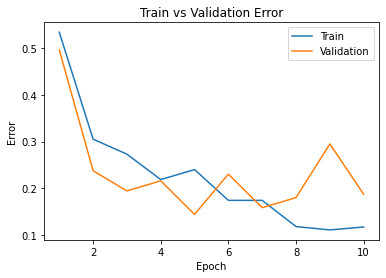

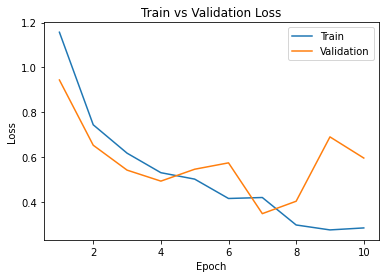

In [ ]:
cnn_net = CNN()
train_net(cnn_net, batch_size=64, learning_rate=0.001)
model_path_cnn = get_model_name("CNN", batch_size=64, learning_rate=0.001, epoch=9)
plot_training_curve(model_path_cnn)

###VGG

Calculate the feature with VGG network

In [ ]:
def vgg_net(batch_size):
    train_features, val_features, test_features = [], [], []
    for i, data in enumerate(train_data_loader_proc, 0):
        images, labels = data
        train_features.append((torch.from_numpy(vgg.features(images).detach().numpy()), labels))
        print ("Extracting train_feature of the %d batch Finished. " % i)
    for i, data in enumerate(val_data_loader_proc, 0):
        images, labels = data
        val_features.append((torch.from_numpy(vgg.features(images).detach().numpy()), labels))
        print ("Extracting val_feature of the %d batch Finished. " % i)
    for i, data in enumerate(test_data_loader_proc, 0):
        images, labels = data
        test_features.append((torch.from_numpy(vgg.features(images).detach().numpy()), labels))
        print ("Extracting test_feature of the %d batch Finished. " % i)
    return train_features, val_features, test_features

Create the Classifier for VGG network, currently with three fully-connected layers

In [ ]:
class vgg_CNN_classifier(nn.Module):
    def __init__(self):
        super(vgg_CNN_classifier, self).__init__()
        self.name = "vgg_CNN"
        self.fc1 = nn.Linear(7*7*512, 256)
        self.fc2 = nn.Linear(256, 32)
        self.fc3 = nn.Linear(32, 4)

    def forward(self, x):
        x = x.view(-1, 7*7*512)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
train_features_vgg, val_features_vgg, test_features_vgg = vgg_net(batch_size)

Extracting train_feature of the 0 batch Finished. 
Extracting train_feature of the 1 batch Finished. 
Extracting train_feature of the 2 batch Finished. 
Extracting train_feature of the 3 batch Finished. 
Extracting train_feature of the 4 batch Finished. 
Extracting train_feature of the 5 batch Finished. 
Extracting train_feature of the 6 batch Finished. 
Extracting train_feature of the 7 batch Finished. 
Extracting train_feature of the 8 batch Finished. 
Extracting train_feature of the 9 batch Finished. 
Extracting train_feature of the 10 batch Finished. 
Extracting train_feature of the 11 batch Finished. 
Extracting train_feature of the 12 batch Finished. 
Extracting train_feature of the 13 batch Finished. 
Extracting train_feature of the 14 batch Finished. 
Extracting train_feature of the 15 batch Finished. 
Extracting train_feature of the 16 batch Finished. 
Extracting train_feature of the 17 batch Finished. 
Extracting val_feature of the 0 batch Finished. 
Extracting val_feature of

In [ ]:
def train_vgg_classifier(model, batch_size=20, num_epochs=1):
    #train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    # train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           #num_workers=num_workers, shuffle=True)
    # train_data_loader, val_data_loader, test_data_loader, classes, train_features, val_features, test_features = res_net(batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.4, weight_decay=0.3)

    iters, losses, train_acc, val_acc, val_losses = [], [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        Mini_batch_total = 0
        for i, data in enumerate(train_features_vgg, 0):
          
            
            #############################################
            #############################################

          #### ALNC is alexNet.features (AlexNet without classifier) ####
            inputs, labels = data
            out = model(inputs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch



            ##### Mini_batch Accuracy ##### We don't compute accuracy on the whole trainig set in every iteration!
            # pred = out.max(1, keepdim=True)[1]
            # mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            # Mini_batch_total = inputs.shape[0]
            # train_acc.append((mini_batch_correct / Mini_batch_total))
           ###########################
        for i, data in enumerate(val_features_vgg, 0):
          
            
            #############################################
            #############################################

          #### ALNC is alexNet.features (AlexNet without classifier) ####
            inputs, labels = data
            out = model(inputs)             # forward pass
            val_loss = criterion(out, labels) # compute the total loss

          # save the current training information
        iters.append(n)
        val_losses.append(float(val_loss)/(i+1))
        losses.append(float(loss)/(i+1))             # compute *average* loss
        val_acc.append(get_accuracy(model, val_features_vgg, batch_size=64))  # compute validation accuracy
        train_acc.append(get_accuracy(model, train_features_vgg, batch_size=64))
        n += 1
            # mini_b += 1
            # print("Iteration: ",n,'Progress: % 6.2f ' % ((epoch * len(train_features) + mini_b) / (num_epochs * len(train_features))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))


        print ("Epoch %d Finished. " % epoch ,"Epoch accuracy {}".format(get_accuracy(model, train_features_vgg, batch_size=batch_size)), "Validation accuracy {}".
               format(get_accuracy(model, val_features_vgg, batch_size=batch_size)))


    end_time= time.time()
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.plot(iters, val_losses, label="Validation")    
    plt.xlabel("Epoches")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Validation")    
    plt.xlabel("Epoches")
    plt.ylabel("Validation Accuracy")
    plt.legend(loc='best')
    plt.show()

    train_acc.append(get_accuracy(model, train_features_vgg, batch_size=batch_size))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))


Epoch 0 Finished.  Epoch accuracy 0.7457627118644068 Validation accuracy 0.7050359712230215
Epoch 1 Finished.  Epoch accuracy 0.8242640499553969 Validation accuracy 0.8345323741007195
Epoch 2 Finished.  Epoch accuracy 0.8581623550401427 Validation accuracy 0.8345323741007195
Epoch 3 Finished.  Epoch accuracy 0.8849241748438894 Validation accuracy 0.841726618705036
Epoch 4 Finished.  Epoch accuracy 0.9161462979482605 Validation accuracy 0.8345323741007195
Epoch 5 Finished.  Epoch accuracy 0.936663693131133 Validation accuracy 0.8273381294964028
Epoch 6 Finished.  Epoch accuracy 0.9509366636931311 Validation accuracy 0.8201438848920863
Epoch 7 Finished.  Epoch accuracy 0.9598572702943801 Validation accuracy 0.8273381294964028
Epoch 8 Finished.  Epoch accuracy 0.9705619982158786 Validation accuracy 0.8201438848920863
Epoch 9 Finished.  Epoch accuracy 0.9803746654772525 Validation accuracy 0.8273381294964028
Epoch 10 Finished.  Epoch accuracy 0.9884032114183765 Validation accuracy 0.834532

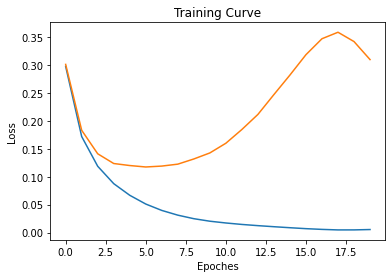

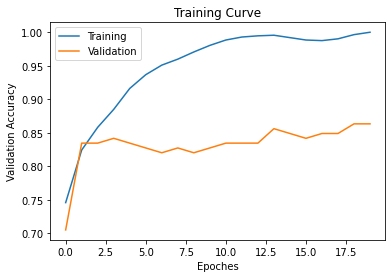

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.8633093525179856
Total time:   35.61 s  Time per Epoch:   1.78 s 


In [ ]:
vgg_model_classifier = vgg_CNN_classifier()
#proper model
train_vgg_classifier(vgg_model_classifier, batch_size=64, num_epochs=20)

###ResNet

In [ ]:
def res_net(batch_size):
    train_features, val_features, test_features = [], [], []
    feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-2])
    for i, data in enumerate(train_data_loader_proc, 0):
        images, labels = data
        train_features.append((torch.from_numpy(feature_extractor(images).detach().numpy()), labels))
        print ("Extracting train_feature of the %d batch Finished. " % i)
    for i, data in enumerate(val_data_loader_proc, 0):
        images, labels = data
        val_features.append((torch.from_numpy(feature_extractor(images).detach().numpy()), labels))
        print ("Extracting val_feature of the %d batch Finished. " % i)
    for i, data in enumerate(test_data_loader_proc, 0):
        images, labels = data
        test_features.append((torch.from_numpy(feature_extractor(images).detach().numpy()), labels))
        print ("Extracting test_feature of the %d batch Finished. " % i)
    return train_features, val_features, test_features

In [ ]:
class res_CNN_classifier(nn.Module):
    def __init__(self):
        super(res_CNN_classifier, self).__init__()
        self.name = "res_CNN"
        self.fc1 = nn.Linear(512*7*7, 256)
        self.fc2 = nn.Linear(256, 32)
        self.fc3 = nn.Linear(32, 4)

    def forward(self, x):
        x = x.view(-1, 512*7*7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
batch_size = 64
train_features_res, val_features_res, test_features_res = res_net(batch_size)

Extracting train_feature of the 0 batch Finished. 
Extracting train_feature of the 1 batch Finished. 
Extracting train_feature of the 2 batch Finished. 
Extracting train_feature of the 3 batch Finished. 
Extracting train_feature of the 4 batch Finished. 
Extracting train_feature of the 5 batch Finished. 
Extracting train_feature of the 6 batch Finished. 
Extracting train_feature of the 7 batch Finished. 
Extracting train_feature of the 8 batch Finished. 
Extracting train_feature of the 9 batch Finished. 
Extracting train_feature of the 10 batch Finished. 
Extracting train_feature of the 11 batch Finished. 
Extracting train_feature of the 12 batch Finished. 
Extracting train_feature of the 13 batch Finished. 
Extracting train_feature of the 14 batch Finished. 
Extracting train_feature of the 15 batch Finished. 
Extracting train_feature of the 16 batch Finished. 
Extracting train_feature of the 17 batch Finished. 
Extracting val_feature of the 0 batch Finished. 
Extracting val_feature of

In [ ]:
def train_res_classifier(model, batch_size=20, num_epochs=1):
    #train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    # train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           #num_workers=num_workers, shuffle=True)
    # train_data_loader, val_data_loader, test_data_loader, classes, train_features, val_features, test_features = res_net(batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.4)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        Mini_batch_total = 0
        for i, data in enumerate(train_features_res, 0):
          
            
            #############################################
            #############################################

          #### ALNC is alexNet.features (AlexNet without classifier) ####
            inputs, labels = data
            out = model(inputs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch



            ##### Mini_batch Accuracy ##### We don't compute accuracy on the whole trainig set in every iteration!
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            Mini_batch_total = inputs.shape[0]
            train_acc.append((mini_batch_correct / Mini_batch_total))
           ###########################

          # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            val_acc.append(get_accuracy(model, val_features_res, batch_size=64))  # compute validation accuracy
            n += 1
            mini_b += 1
            # print("Iteration: ",n,'Progress: % 6.2f ' % ((epoch * len(train_features) + mini_b) / (num_epochs * len(train_features))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))


        print ("Epoch %d Finished. " % epoch ,"Epoch accuracy {}".format(get_accuracy(model, train_features_res, batch_size=batch_size)), "Validation accuracy {}".
               format(get_accuracy(model, val_features_res, batch_size=batch_size)))


    end_time= time.time()
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Validation")    
    plt.xlabel("Iterations")
    plt.ylabel("Validation Accuracy")
    plt.legend(loc='best')
    plt.show()

    train_acc.append(get_accuracy(model, train_features_res, batch_size=batch_size))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))

Epoch 0 Finished.  Epoch accuracy 0.8626226583407671 Validation accuracy 0.7769784172661871
Epoch 1 Finished.  Epoch accuracy 0.8590544157002676 Validation accuracy 0.7553956834532374
Epoch 2 Finished.  Epoch accuracy 0.8661909009812667 Validation accuracy 0.6834532374100719
Epoch 3 Finished.  Epoch accuracy 0.9027653880463872 Validation accuracy 0.7194244604316546
Epoch 4 Finished.  Epoch accuracy 0.9776984834968778 Validation accuracy 0.7985611510791367
Epoch 5 Finished.  Epoch accuracy 0.9901873327386262 Validation accuracy 0.8345323741007195
Epoch 6 Finished.  Epoch accuracy 0.991971454058876 Validation accuracy 0.8201438848920863
Epoch 7 Finished.  Epoch accuracy 0.9964317573595004 Validation accuracy 0.841726618705036
Epoch 8 Finished.  Epoch accuracy 0.9830508474576272 Validation accuracy 0.8273381294964028
Epoch 9 Finished.  Epoch accuracy 0.9955396966993756 Validation accuracy 0.841726618705036


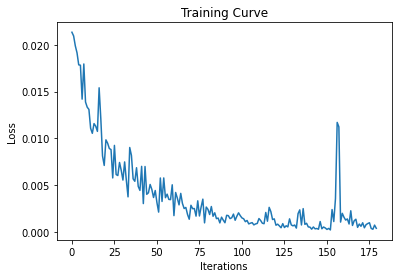

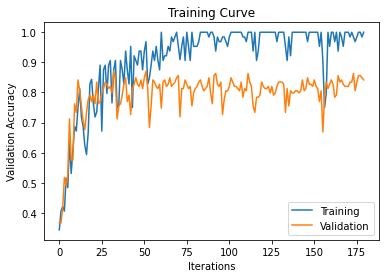

Final Training Accuracy: 0.9955396966993756
Final Validation Accuracy: 0.841726618705036
Total time:   23.29 s  Time per Epoch:   2.33 s 


In [ ]:
res_model_classifier = res_CNN_classifier()
#proper model
train_res_classifier(res_model_classifier, batch_size=64, num_epochs=10)

###GoogleNet

In [ ]:
def google_net(batch_size):
    train_features, val_features, test_features = [], [], []
    feature_extractor = torch.nn.Sequential(*list(googlenet.children())[:-3])
    for i, data in enumerate(train_data_loader, 0):
        images, labels = data
        train_features.append((torch.from_numpy(feature_extractor(images).detach().numpy()), labels))
        print ("Extracting train_feature of the %d batch Finished. " % i)
    for i, data in enumerate(val_data_loader, 0):
        images, labels = data
        val_features.append((torch.from_numpy(feature_extractor(images).detach().numpy()), labels))
        print ("Extracting val_feature of the %d batch Finished. " % i)
    for i, data in enumerate(test_data_loader, 0):
        images, labels = data
        test_features.append((torch.from_numpy(feature_extractor(images).detach().numpy()), labels))
        print ("Extracting test_feature of the %d batch Finished. " % i)
    return train_features, val_features, test_features

In [ ]:
class google_CNN_classifier(nn.Module):
    def __init__(self):
        super(google_CNN_classifier, self).__init__()
        self.name = "google_CNN"
        self.fc1 = nn.Linear(7*7*1024, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 4)

    def forward(self, x):
        x = x.view(-1, 7*7*1024)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
batch_size = 64
train_features_google, val_features_google, test_features_google = google_net(batch_size)

Extracting train_feature of the 0 batch Finished. 
Extracting train_feature of the 1 batch Finished. 
Extracting train_feature of the 2 batch Finished. 
Extracting train_feature of the 3 batch Finished. 
Extracting train_feature of the 4 batch Finished. 
Extracting train_feature of the 5 batch Finished. 
Extracting train_feature of the 6 batch Finished. 
Extracting train_feature of the 7 batch Finished. 
Extracting train_feature of the 8 batch Finished. 
Extracting train_feature of the 9 batch Finished. 
Extracting train_feature of the 10 batch Finished. 
Extracting train_feature of the 11 batch Finished. 
Extracting train_feature of the 12 batch Finished. 
Extracting train_feature of the 13 batch Finished. 
Extracting train_feature of the 14 batch Finished. 
Extracting train_feature of the 15 batch Finished. 
Extracting train_feature of the 16 batch Finished. 
Extracting train_feature of the 17 batch Finished. 
Extracting val_feature of the 0 batch Finished. 
Extracting val_feature of

In [ ]:
def train_google_classifier(model, batch_size=20, num_epochs=1):
    #train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    # train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           #num_workers=num_workers, shuffle=True)
    # train_data_loader, val_data_loader, test_data_loader, classes, train_features, val_features, test_features = res_net(batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.4)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        Mini_batch_total = 0
        for i, data in enumerate(train_features_google, 0):
          
            
            #############################################
            #############################################

          #### ALNC is alexNet.features (AlexNet without classifier) ####
            inputs, labels = data
            out = model(inputs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch



            ##### Mini_batch Accuracy ##### We don't compute accuracy on the whole trainig set in every iteration!
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            Mini_batch_total = inputs.shape[0]
            train_acc.append((mini_batch_correct / Mini_batch_total))
           ###########################

          # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            val_acc.append(get_accuracy(model, val_features_google, batch_size=64))  # compute validation accuracy
            n += 1
            mini_b += 1
            # print("Iteration: ",n,'Progress: % 6.2f ' % ((epoch * len(train_features) + mini_b) / (num_epochs * len(train_features))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))


        print ("Epoch %d Finished. " % epoch ,"Epoch accuracy {}".format(get_accuracy(model, train_features_google, batch_size=batch_size)), "Validation accuracy {}".
               format(get_accuracy(model, val_features_google, batch_size=batch_size)))


    end_time= time.time()
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Validation")    
    plt.xlabel("Iterations")
    plt.ylabel("Validation Accuracy")
    plt.legend(loc='best')
    plt.show()

    train_acc.append(get_accuracy(model, train_features_google, batch_size=batch_size))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))

Epoch 0 Finished.  Epoch accuracy 0.8135593220338984 Validation accuracy 0.7697841726618705
Epoch 1 Finished.  Epoch accuracy 0.8974130240856378 Validation accuracy 0.8345323741007195
Epoch 2 Finished.  Epoch accuracy 0.9455842997323818 Validation accuracy 0.8273381294964028
Epoch 3 Finished.  Epoch accuracy 0.975914362176628 Validation accuracy 0.8273381294964028
Epoch 4 Finished.  Epoch accuracy 0.9910793933987511 Validation accuracy 0.8201438848920863
Epoch 5 Finished.  Epoch accuracy 0.991971454058876 Validation accuracy 0.8129496402877698
Epoch 6 Finished.  Epoch accuracy 0.9946476360392507 Validation accuracy 0.8129496402877698
Epoch 7 Finished.  Epoch accuracy 0.9982158786797503 Validation accuracy 0.8273381294964028
Epoch 8 Finished.  Epoch accuracy 0.9991079393398751 Validation accuracy 0.8201438848920863
Epoch 9 Finished.  Epoch accuracy 1.0 Validation accuracy 0.8345323741007195


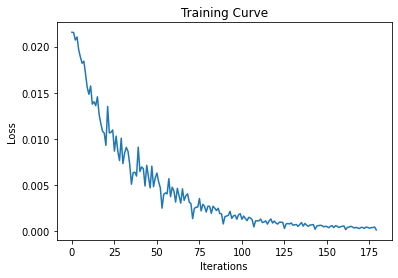

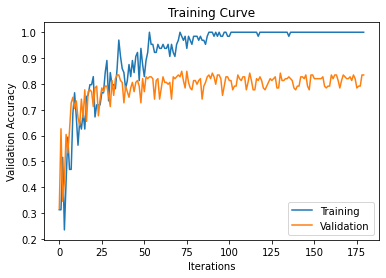

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.8345323741007195
Total time:   81.23 s  Time per Epoch:   8.12 s 


In [ ]:
google_model_classifier = google_CNN_classifier()
#proper model
train_google_classifier(google_model_classifier, batch_size=64, num_epochs=10)

### Classification

In [ ]:
class vgg_CNN_classifier_var1(nn.Module):
    def __init__(self):
        super(vgg_CNN_classifier_var1, self).__init__()
        self.name = "vgg_CNN_var1"
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(512*7*7, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = x.view(-1, 512*7*7)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # x = x.squeeze(1) # Flatten to [batch_size]
        return x

Epoch 0 Finished.  Epoch accuracy 0.7823371989295272 Validation accuracy 0.8057553956834532
Epoch 1 Finished.  Epoch accuracy 0.8661909009812667 Validation accuracy 0.8345323741007195
Epoch 2 Finished.  Epoch accuracy 0.8795718108831401 Validation accuracy 0.8489208633093526
Epoch 3 Finished.  Epoch accuracy 0.9027653880463872 Validation accuracy 0.8633093525179856
Epoch 4 Finished.  Epoch accuracy 0.9179304192685103 Validation accuracy 0.8489208633093526
Epoch 5 Finished.  Epoch accuracy 0.9223907225691347 Validation accuracy 0.841726618705036
Epoch 6 Finished.  Epoch accuracy 0.9339875111507583 Validation accuracy 0.841726618705036
Epoch 7 Finished.  Epoch accuracy 0.9491525423728814 Validation accuracy 0.8273381294964028
Epoch 8 Finished.  Epoch accuracy 0.9491525423728814 Validation accuracy 0.8561151079136691
Epoch 9 Finished.  Epoch accuracy 0.936663693131133 Validation accuracy 0.8345323741007195
Epoch 10 Finished.  Epoch accuracy 0.9536128456735058 Validation accuracy 0.8489208

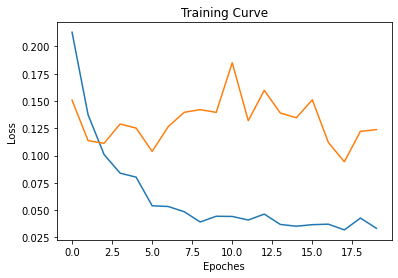

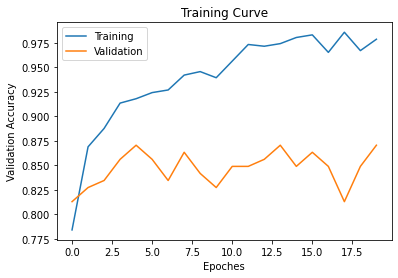

Final Training Accuracy: 0.9803746654772525
Final Validation Accuracy: 0.8705035971223022
Total time:   30.23 s  Time per Epoch:   1.51 s 


In [ ]:
vgg_model_classifier_var1 = vgg_CNN_classifier_var1()
#proper model
train_vgg_classifier(vgg_model_classifier_var1, batch_size=64, num_epochs=20)

In [ ]:
class vgg_CNN_classifier_var2(nn.Module):
    def __init__(self):
        super(vgg_CNN_classifier_var2, self).__init__()
        self.name = "vgg_CNN_var2"
        self.fc1 = nn.Linear(512*7*7, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 4)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.view(-1, 512*7*7)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # x = x.squeeze(1) # Flatten to [batch_size]
        return x

Epoch 0 Finished.  Epoch accuracy 0.6984834968777877 Validation accuracy 0.6762589928057554
Epoch 1 Finished.  Epoch accuracy 0.8260481712756468 Validation accuracy 0.8345323741007195
Epoch 2 Finished.  Epoch accuracy 0.8438893844781445 Validation accuracy 0.8705035971223022
Epoch 3 Finished.  Epoch accuracy 0.8599464763603925 Validation accuracy 0.8776978417266187
Epoch 4 Finished.  Epoch accuracy 0.8670829616413916 Validation accuracy 0.8561151079136691
Epoch 5 Finished.  Epoch accuracy 0.8751115075825157 Validation accuracy 0.8776978417266187
Epoch 6 Finished.  Epoch accuracy 0.8813559322033898 Validation accuracy 0.8848920863309353
Epoch 7 Finished.  Epoch accuracy 0.8938447814451382 Validation accuracy 0.8920863309352518
Epoch 8 Finished.  Epoch accuracy 0.8974130240856378 Validation accuracy 0.8848920863309353
Epoch 9 Finished.  Epoch accuracy 0.8991971454058876 Validation accuracy 0.8920863309352518
Epoch 10 Finished.  Epoch accuracy 0.9027653880463872 Validation accuracy 0.8776

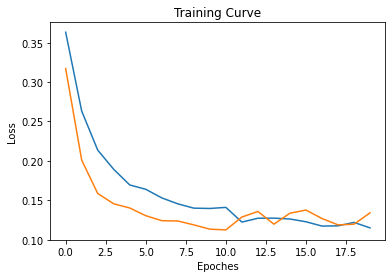

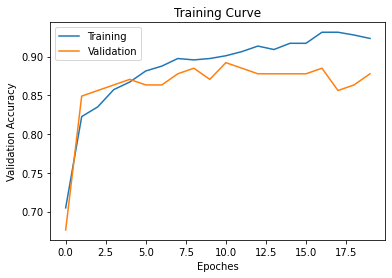

Final Training Accuracy: 0.9304192685102587
Final Validation Accuracy: 0.8776978417266187
Total time:   158.11 s  Time per Epoch:   7.91 s 


In [ ]:
vgg_model_classifier_var2 = vgg_CNN_classifier_var2()
#proper model
train_vgg_classifier(vgg_model_classifier_var2, batch_size=64, num_epochs=20)

In [ ]:
def train_vgg_classifier_var1(model, train_features, val_features, batch_size=20, num_epochs=1):
    #train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    # train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           #num_workers=num_workers, shuffle=True)
    # train_data_loader, val_data_loader, test_data_loader, classes, train_features, val_features, test_features = res_net(batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.4, weight_decay=0.15)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        Mini_batch_total = 0
        for i, data in enumerate(train_features, 0):
          
            
            #############################################
            #############################################

          #### ALNC is alexNet.features (AlexNet without classifier) ####
            inputs, labels = data
            out = model(inputs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch



            ##### Mini_batch Accuracy ##### We don't compute accuracy on the whole trainig set in every iteration!
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            Mini_batch_total = inputs.shape[0]
            train_acc.append((mini_batch_correct / Mini_batch_total))
           ###########################

          # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            val_acc.append(get_accuracy(model, val_features, batch_size=64))  # compute validation accuracy
            n += 1
            mini_b += 1
            # print("Iteration: ",n,'Progress: % 6.2f ' % ((epoch * len(train_features) + mini_b) / (num_epochs * len(train_features))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))


        print ("Epoch %d Finished. " % epoch ,"Epoch accuracy {}".format(get_accuracy(model, train_features, batch_size=batch_size)), "Validation accuracy {}".
               format(get_accuracy(model, val_features, batch_size=batch_size)))


    end_time= time.time()
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Validation")    
    plt.xlabel("Iterations")
    plt.ylabel("Validation Accuracy")
    plt.legend(loc='best')
    plt.show()

    train_acc.append(get_accuracy(model, train_features, batch_size=batch_size))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))


In [ ]:
vgg_model_classifier_var2 = vgg_CNN_classifier_var2()
#proper model
train_vgg_classifier_var1(vgg_model_classifier_var2, train_features_vgg, val_features_vgg, batch_size=64, num_epochs=20)

### Processed Data

In [ ]:
def vgg_net_proc(batch_size):
    train_features, val_features, test_features = [], [], []
    for i, data in enumerate(train_data_loader_proc, 0):
        images, labels = data
        train_features.append((torch.from_numpy(vgg.features(images).detach().numpy()), labels))
        print ("Extracting train_feature of the %d batch Finished. " % i)
    for i, data in enumerate(val_data_loader_proc, 0):
        images, labels = data
        val_features.append((torch.from_numpy(vgg.features(images).detach().numpy()), labels))
        print ("Extracting val_feature of the %d batch Finished. " % i)
    for i, data in enumerate(test_data_loader_proc, 0):
        images, labels = data
        test_features.append((torch.from_numpy(vgg.features(images).detach().numpy()), labels))
        print ("Extracting test_feature of the %d batch Finished. " % i)
    return train_features, val_features, test_features

In [ ]:
train_features_vgg_proc, val_features_vgg_proc, test_features_vgg_proc = vgg_net_proc(batch_size)

Extracting train_feature of the 0 batch Finished. 
Extracting train_feature of the 1 batch Finished. 
Extracting train_feature of the 2 batch Finished. 
Extracting train_feature of the 3 batch Finished. 
Extracting train_feature of the 4 batch Finished. 
Extracting train_feature of the 5 batch Finished. 
Extracting train_feature of the 6 batch Finished. 
Extracting train_feature of the 7 batch Finished. 
Extracting train_feature of the 8 batch Finished. 
Extracting train_feature of the 9 batch Finished. 
Extracting train_feature of the 10 batch Finished. 
Extracting train_feature of the 11 batch Finished. 
Extracting train_feature of the 12 batch Finished. 
Extracting train_feature of the 13 batch Finished. 
Extracting train_feature of the 14 batch Finished. 
Extracting train_feature of the 15 batch Finished. 
Extracting train_feature of the 16 batch Finished. 
Extracting train_feature of the 17 batch Finished. 
Extracting val_feature of the 0 batch Finished. 
Extracting val_feature of

Epoch 0 Finished.  Epoch accuracy 0.7216770740410348 Validation accuracy 0.7482014388489209
Epoch 1 Finished.  Epoch accuracy 0.7983942908117752 Validation accuracy 0.7769784172661871
Epoch 2 Finished.  Epoch accuracy 0.8331846565566459 Validation accuracy 0.8345323741007195
Epoch 3 Finished.  Epoch accuracy 0.8670829616413916 Validation accuracy 0.8561151079136691
Epoch 4 Finished.  Epoch accuracy 0.8831400535236396 Validation accuracy 0.8273381294964028
Epoch 5 Finished.  Epoch accuracy 0.8983050847457628 Validation accuracy 0.8561151079136691
Epoch 6 Finished.  Epoch accuracy 0.9081177520071365 Validation accuracy 0.8705035971223022
Epoch 7 Finished.  Epoch accuracy 0.9125780553077609 Validation accuracy 0.8776978417266187
Epoch 8 Finished.  Epoch accuracy 0.9107939339875112 Validation accuracy 0.8345323741007195
Epoch 9 Finished.  Epoch accuracy 0.9375557537912578 Validation accuracy 0.8561151079136691
Epoch 10 Finished.  Epoch accuracy 0.9313113291703836 Validation accuracy 0.8705

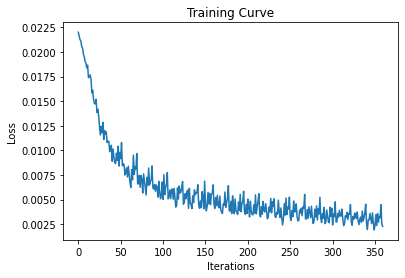

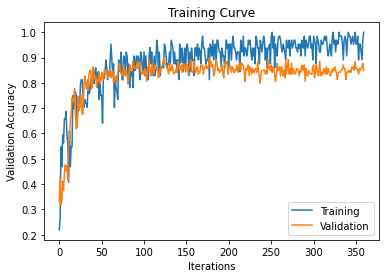

Final Training Accuracy: 0.9616413916146298
Final Validation Accuracy: 0.8489208633093526
Total time:   171.94 s  Time per Epoch:   8.60 s 


In [ ]:
vgg_model_classifier_var2_proc = vgg_CNN_classifier_var2()
#proper model
train_vgg_classifier_var1(vgg_model_classifier_var2_proc, train_features_vgg_proc, val_features_vgg_proc, batch_size=64, num_epochs=20)

In [ ]:
val_path= "/content/gdrive/My Drive/360 Project/ct_gamma_hist/Validation"
# set fix size
transform = transforms.Compose(
            [transforms.Resize((224,224)), transforms.ToTensor(), 
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

val_data = torchvision.datasets.ImageFolder(root=val_path,transform=transform)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, 
                                          num_workers=1, shuffle=True)
val_features = []
for i, data in enumerate(val_loader, 0):
    images, labels = data
    val_features.append((torch.from_numpy(vgg.features(images).detach().numpy()), labels))
    print ("Extracting val_feature of the %d batch Finished. " % i)

Extracting val_feature of the 0 batch Finished. 
Extracting val_feature of the 1 batch Finished. 
Extracting val_feature of the 2 batch Finished. 
Extracting val_feature of the 3 batch Finished. 
Extracting val_feature of the 4 batch Finished. 
Extracting val_feature of the 5 batch Finished. 
Extracting val_feature of the 6 batch Finished. 
Extracting val_feature of the 7 batch Finished. 
Extracting val_feature of the 8 batch Finished. 
Extracting val_feature of the 9 batch Finished. 
Extracting val_feature of the 10 batch Finished. 
Extracting val_feature of the 11 batch Finished. 
Extracting val_feature of the 12 batch Finished. 
Extracting val_feature of the 13 batch Finished. 
Extracting val_feature of the 14 batch Finished. 
Extracting val_feature of the 15 batch Finished. 
Extracting val_feature of the 16 batch Finished. 
Extracting val_feature of the 17 batch Finished. 
Extracting val_feature of the 18 batch Finished. 
Extracting val_feature of the 19 batch Finished. 
Extracting

In [ ]:
# 存model用的，不用run
path = "/content/gdrive/MyDrive/360 Project/model_saved_for_confusion_matrix"
torch.save(vgg_model_classifier_var2_proc.state_dict(), path)

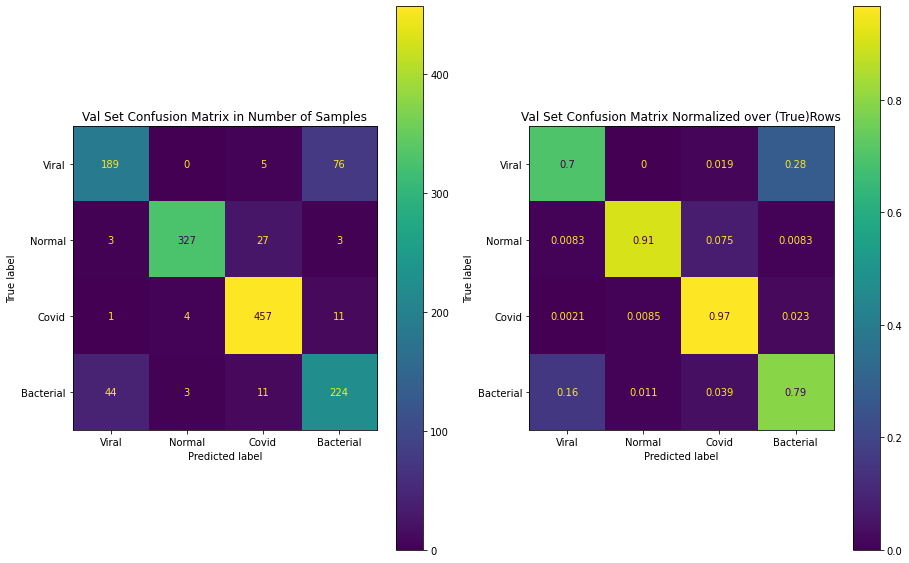

In [ ]:
from sklearn import metrics
path = "/content/gdrive/MyDrive/360 Project/model_saved_for_confusion_matrix"

net = vgg_CNN_classifier_var2()
state = torch.load(path)
net.load_state_dict(state)

output = net(val_features[0][0])
pred = output.max(1, keepdim=True)[1]
true = val_features[0][1]
for i in range(len(val_features)-1):
    output = net(val_features[i+1][0])
    pred = torch.cat((pred,output.max(1, keepdim=True)[1]),0)
    true = torch.cat((true,val_features[i+1][1]))

classes = ['Viral', 'Normal', 'Covid', 'Bacterial']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
ax = axes.flatten()
axes[0].set_title("Val Set Confusion Matrix in Number of Samples")
axes[1].set_title("Val Set Confusion Matrix Normalized over (True)Rows")

cm = metrics.confusion_matrix(y_true=true, y_pred=pred, normalize=None)
disp= metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(ax=ax[0], values_format='d')
cm = metrics.confusion_matrix(y_true=true, y_pred=pred, normalize='true')
disp= metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(ax=ax[1])

plt.show()

In [ ]:
val_data_VGG = []
val_label_VGG = []
i = 0
for x, y in val_features_vgg_proc:
  val_data_VGG.append(x)
  val_label_VGG.append(y)
  i = i + 1
  if i == 1:
      break

val_data_VGG = torch.stack(val_data_VGG)
val_label_VGG = torch.stack(val_label_VGG)

### Train on all the data

In [ ]:
def get_data_loader_normalize_proc_all(batch_size):
    train_path= "/content/gdrive/My Drive/360 Project/ct_gamma_hist/Train"
    val_path= "/content/gdrive/My Drive/360 Project/ct_gamma_hist/Validation"
    test_path= "/content/gdrive/My Drive/360 Project/ct_gamma_hist/Test"

    # set fix size
    transform = transforms.Compose(
            [transforms.Resize((224,224)), transforms.ToTensor(), 
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    train_data = torchvision.datasets.ImageFolder(root=train_path,transform=transform)
    val_data = torchvision.datasets.ImageFolder(root=val_path,transform=transform)
    test_data = torchvision.datasets.ImageFolder(root=test_path,transform=transform)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                            num_workers=1, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                            num_workers=1, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                            num_workers=1, shuffle=True)

    classes = ['Viral', 'Normal', 'Covid', 'Bacterial']
    return train_loader, val_loader, test_loader, classes

In [ ]:
batch_size = 64
train_data_loader_proc_all, val_data_loader_proc_all, test_data_loader_proc_all, classes = get_data_loader_normalize_proc_all(batch_size)

In [ ]:
def vgg_net_proc_all(batch_size, train, val, test):
    train_features, val_features, test_features = [], [], []
    for i, data in enumerate(train, 0):
        images, labels = data
        train_features.append((torch.from_numpy(vgg.features(images).detach().numpy()), labels))
        print ("Extracting train_feature of the %d batch Finished. " % i)
    for i, data in enumerate(val, 0):
        images, labels = data
        val_features.append((torch.from_numpy(vgg.features(images).detach().numpy()), labels))
        print ("Extracting val_feature of the %d batch Finished. " % i)
    for i, data in enumerate(test, 0):
        images, labels = data
        test_features.append((torch.from_numpy(vgg.features(images).detach().numpy()), labels))
        print ("Extracting test_feature of the %d batch Finished. " % i)
    return train_features, val_features, test_features

In [ ]:
train_features_vgg_proc_all, val_features_vgg_proc_all, test_features_vgg_proc_all = vgg_net_proc_all(batch_size,
                                                                                                      train_data_loader_proc_all, val_data_loader_proc_all, test_data_loader_proc_all)

Extracting train_feature of the 0 batch Finished. 
Extracting train_feature of the 1 batch Finished. 
Extracting train_feature of the 2 batch Finished. 
Extracting train_feature of the 3 batch Finished. 
Extracting train_feature of the 4 batch Finished. 
Extracting train_feature of the 5 batch Finished. 
Extracting train_feature of the 6 batch Finished. 
Extracting train_feature of the 7 batch Finished. 
Extracting train_feature of the 8 batch Finished. 
Extracting train_feature of the 9 batch Finished. 
Extracting train_feature of the 10 batch Finished. 
Extracting train_feature of the 11 batch Finished. 
Extracting train_feature of the 12 batch Finished. 
Extracting train_feature of the 13 batch Finished. 
Extracting train_feature of the 14 batch Finished. 
Extracting train_feature of the 15 batch Finished. 
Extracting train_feature of the 16 batch Finished. 
Extracting train_feature of the 17 batch Finished. 
Extracting train_feature of the 18 batch Finished. 
Extracting train_featu

In [ ]:
def train_vgg_classifier_var2(model, train_features, val_features, batch_size=20, num_epochs=1, wd=0.05):
    #train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    # train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           #num_workers=num_workers, shuffle=True)
    # train_data_loader, val_data_loader, test_data_loader, classes, train_features, val_features, test_features = res_net(batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.4, weight_decay=wd)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        Mini_batch_total = 0
        for i, data in enumerate(train_features, 0):
          
            
            #############################################
            #############################################

          #### ALNC is alexNet.features (AlexNet without classifier) ####
            inputs, labels = data
            out = model(inputs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch



            ##### Mini_batch Accuracy ##### We don't compute accuracy on the whole trainig set in every iteration!
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            Mini_batch_total = inputs.shape[0]
            train_acc.append((mini_batch_correct / Mini_batch_total))
           ###########################

          # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            val_acc.append(get_accuracy(model, val_features, batch_size=64))  # compute validation accuracy
            n += 1
            mini_b += 1
            # print("Iteration: ",n,'Progress: % 6.2f ' % ((epoch * len(train_features) + mini_b) / (num_epochs * len(train_features))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))


        print ("Epoch %d Finished. " % epoch ,"Epoch accuracy {}".format(get_accuracy(model, train_features, batch_size=batch_size)), "Validation accuracy {}".
               format(get_accuracy(model, val_features, batch_size=batch_size)))


    end_time= time.time()
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Validation")    
    plt.xlabel("Iterations")
    plt.ylabel("Validation Accuracy")
    plt.legend(loc='best')
    plt.show()

    train_acc.append(get_accuracy(model, train_features, batch_size=batch_size))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))

Epoch 0 Finished.  Epoch accuracy 0.8857346902338868 Validation accuracy 0.8801444043321299
Epoch 1 Finished.  Epoch accuracy 0.9168005713265488 Validation accuracy 0.8974729241877256
Epoch 2 Finished.  Epoch accuracy 0.9330476700589181 Validation accuracy 0.9032490974729241
Epoch 3 Finished.  Epoch accuracy 0.945009819675058 Validation accuracy 0.903971119133574
Epoch 4 Finished.  Epoch accuracy 0.9542046063202999 Validation accuracy 0.9111913357400722
Epoch 5 Finished.  Epoch accuracy 0.9586680949830387 Validation accuracy 0.9104693140794223
Epoch 6 Finished.  Epoch accuracy 0.9612569184074272 Validation accuracy 0.9111913357400722
Epoch 7 Finished.  Epoch accuracy 0.962953044099268 Validation accuracy 0.9104693140794223


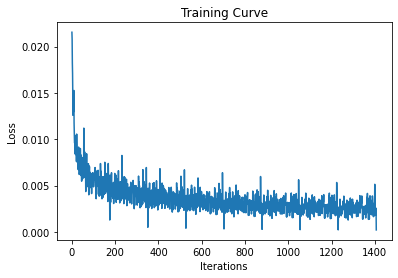

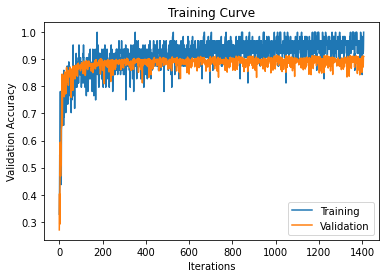

Final Training Accuracy: 0.962953044099268
Final Validation Accuracy: 0.9104693140794223
Total time:   348.28 s  Time per Epoch:  43.54 s 


In [ ]:
vgg_model_classifier_var1_proc_all = vgg_CNN_classifier_var1()
#proper model
train_vgg_classifier_var2(vgg_model_classifier_var1_proc_all, train_features_vgg_proc_all, val_features_vgg_proc_all, batch_size=64, num_epochs=8,wd=0.06)

Epoch 0 Finished.  Epoch accuracy 0.8381539010890913 Validation accuracy 0.8245487364620938
Epoch 1 Finished.  Epoch accuracy 0.8938582396000714 Validation accuracy 0.8895306859205776
Epoch 2 Finished.  Epoch accuracy 0.9067130869487592 Validation accuracy 0.8996389891696751
Epoch 3 Finished.  Epoch accuracy 0.9222460274950902 Validation accuracy 0.8981949458483754
Epoch 4 Finished.  Epoch accuracy 0.9326013211926442 Validation accuracy 0.9010830324909748
Epoch 5 Finished.  Epoch accuracy 0.9371540796286377 Validation accuracy 0.9018050541516246
Epoch 6 Finished.  Epoch accuracy 0.950990894483128 Validation accuracy 0.8974729241877256
Epoch 7 Finished.  Epoch accuracy 0.9558114622388859 Validation accuracy 0.9025270758122743
Epoch 8 Finished.  Epoch accuracy 0.937064809855383 Validation accuracy 0.8779783393501805
Epoch 9 Finished.  Epoch accuracy 0.9586680949830387 Validation accuracy 0.8945848375451263


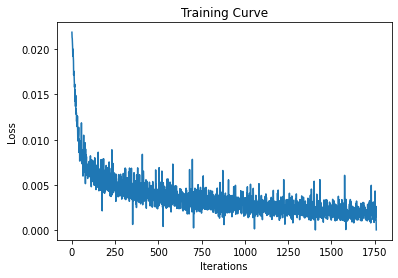

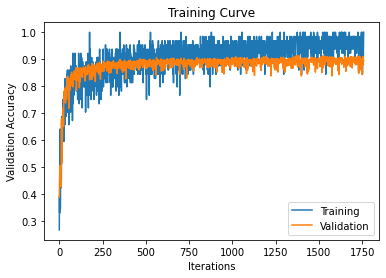

Final Training Accuracy: 0.9607212997678986
Final Validation Accuracy: 0.8953068592057761
Total time:   3189.88 s  Time per Epoch:  318.99 s 


In [ ]:
vgg_model_classifier_var2_proc_all = vgg_CNN_classifier_var2()
train_vgg_classifier_var2(vgg_model_classifier_var2_proc_all, train_features_vgg_proc_all, val_features_vgg_proc_all, batch_size=64, num_epochs=10, wd=0.015)

In [ ]:
model_save_name1 = "model_{0}_bs{1}_training_Method{2}_wd{3}.pt".format(vgg_model_classifier_var1_proc_all.name,
                                                   batch_size, "var2", 0.06)
path1 = F"/content/gdrive/My Drive/360 Project/{model_save_name1}"
torch.save(vgg_model_classifier_var1_proc_all.state_dict(), path1)

In [ ]:
path1 = F"/content/gdrive/MyDrive/360 Project/test_proc_1_tenth"
model1 = vgg_CNN_classifier_var1()
model1.load_state_dict(torch.load(path1))

<All keys matched successfully>

In [ ]:
path1 = F"/content/gdrive/MyDrive/360 Project/model_vgg_CNN_var1_bs64_training_Methodvar2_wd0.06.pt"
model1 = vgg_CNN_classifier_var1()
model1.load_state_dict(torch.load(path1))

<All keys matched successfully>

In [ ]:
model_save_name2 = "model_{0}_bs{1}_training_Method{2}_wd{3}.pt".format(vgg_model_classifier_var2_proc_all.name,
                                                   batch_size, "var2", 0.015)
path2 = F"/content/gdrive/My Drive/360 Project/{model_save_name2}"
torch.save(vgg_model_classifier_var2_proc_all.state_dict(), path2)

In [ ]:
model2 = vgg_CNN_classifier_var2()
model2.load_state_dict(torch.load(path2))

<All keys matched successfully>

In [ ]:
path1 = F"/content/gdrive/MyDrive/360 Project/test_proc_1_third"
model1 = vgg_CNN_classifier_var1()
model1.load_state_dict(torch.load(path1))

### Test

In [ ]:
def get_test_accuracy(model, features, batch_size=64):
    correct = 0
    total = 0
    for i, data in enumerate(features, 0):
        inputs, labels = data
        output = model(inputs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += inputs.shape[0]
    return correct / total

In [ ]:
print(("Test accuracy: {}").format(
            get_test_accuracy(model1, test_features_vgg_proc_all, batch_size=64)))

Test accuracy: 0.9314079422382672


In [ ]:
# val_path= "/content/gdrive/My Drive/360 Project/ct_gamma_hist/Validation"
val_path= "/content/gdrive/My Drive/360 Project/new_test_data1"
# test_path= "/content/gdrive/My Drive/360 Project/ct_gamma_hist/Test"
test_path= "/content/gdrive/My Drive/360 Project/new_test_data1"

# set fix size
transform = transforms.Compose(
        [transforms.Resize((224,224)), transforms.ToTensor(), 
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

val_data = torchvision.datasets.ImageFolder(root=val_path,transform=transform)
test_data = torchvision.datasets.ImageFolder(root=test_path,transform=transform)

val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, 
                                        num_workers=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, 
                                        num_workers=1, shuffle=True)

val_features = []
for i, data in enumerate(val_loader, 0):
    images, labels = data
    val_features.append((torch.from_numpy(vgg.features(images).detach().numpy()), labels))
    print ("Extracting val_feature of the %d batch Finished. " % i)
test_features = []
for i, data in enumerate(test_loader, 0):
    images, labels = data
    test_features.append((torch.from_numpy(vgg.features(images).detach().numpy()), labels))
    print ("Extracting test_feature of the %d batch Finished. " % i)

Extracting val_feature of the 0 batch Finished. 
Extracting val_feature of the 1 batch Finished. 
Extracting val_feature of the 2 batch Finished. 
Extracting val_feature of the 3 batch Finished. 
Extracting val_feature of the 4 batch Finished. 
Extracting val_feature of the 5 batch Finished. 
Extracting val_feature of the 6 batch Finished. 
Extracting val_feature of the 7 batch Finished. 
Extracting val_feature of the 8 batch Finished. 
Extracting test_feature of the 0 batch Finished. 
Extracting test_feature of the 1 batch Finished. 
Extracting test_feature of the 2 batch Finished. 
Extracting test_feature of the 3 batch Finished. 
Extracting test_feature of the 4 batch Finished. 
Extracting test_feature of the 5 batch Finished. 
Extracting test_feature of the 6 batch Finished. 
Extracting test_feature of the 7 batch Finished. 
Extracting test_feature of the 8 batch Finished. 


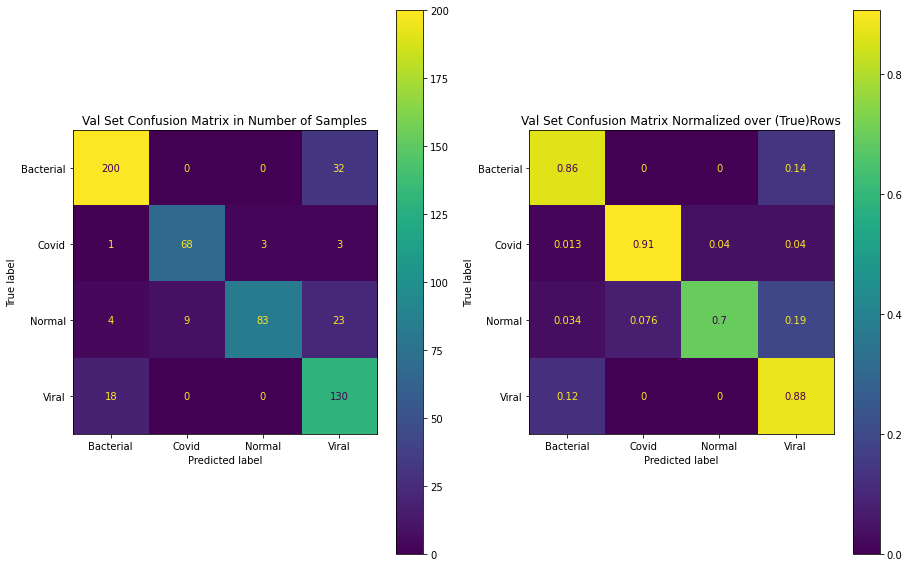

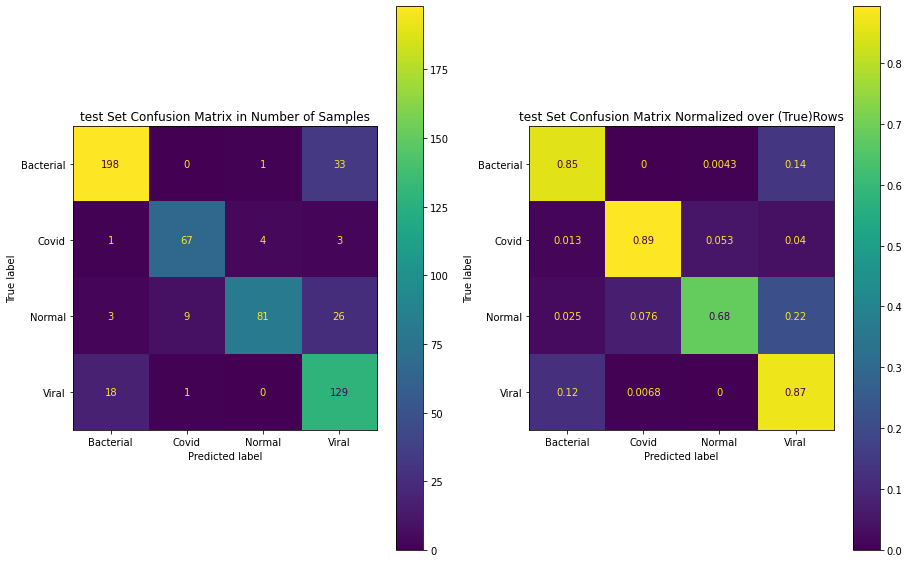

In [ ]:
from sklearn import metrics
# model path
path = "/content/gdrive/MyDrive/360 Project/model_vgg_CNN_var1_bs64_training_Methodvar2_wd0.06.pt"

# path model
net = vgg_CNN_classifier_var1()
state = torch.load(path)
net.load_state_dict(state)

# confusion matrix of val set
output = net(val_features[0][0])
pred = output.max(1, keepdim=True)[1]
true = val_features[0][1]
for i in range(len(val_features)-1):
    output = net(val_features[i+1][0])
    pred = torch.cat((pred,output.max(1, keepdim=True)[1]),0)
    true = torch.cat((true,val_features[i+1][1]))

classes = ['Bacterial', 'Covid', 'Normal', 'Viral']   

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
ax = axes.flatten()
axes[0].set_title("Val Set Confusion Matrix in Number of Samples")
axes[1].set_title("Val Set Confusion Matrix Normalized over (True)Rows")

cm = metrics.confusion_matrix(y_true=true, y_pred=pred, normalize=None)
disp= metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(ax=ax[0], values_format='d')
cm = metrics.confusion_matrix(y_true=true, y_pred=pred, normalize='true')
disp= metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(ax=ax[1])

plt.show()

# confusiong matrix of test set
output = net(test_features[0][0])
pred = output.max(1, keepdim=True)[1]
true = test_features[0][1]
for i in range(len(test_features)-1):
    output = net(test_features[i+1][0])
    pred = torch.cat((pred,output.max(1, keepdim=True)[1]),0)
    true = torch.cat((true,test_features[i+1][1]))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
ax = axes.flatten()
axes[0].set_title("test Set Confusion Matrix in Number of Samples")
axes[1].set_title("test Set Confusion Matrix Normalized over (True)Rows")

cm = metrics.confusion_matrix(y_true=true, y_pred=pred, normalize=None)
disp= metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(ax=ax[0], values_format='d')
cm = metrics.confusion_matrix(y_true=true, y_pred=pred, normalize='true')
disp= metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(ax=ax[1])

plt.show()

Web app

In [ ]:
pip install anvil-uplink

In [ ]:
import anvil.server

anvil.server.connect("YECYCCS7BK6RSOYMXHGTPROC-QZT3HJHJ3HZZJPTG")


Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment (dev)" as SERVER


In [ ]:
train_path= "/content/gdrive/My Drive/360 Project/ct_gamma_hist/Train"
val_path= "/content/gdrive/My Drive/360 Project/ct_gamma_hist/Validation"
test_path= "/content/gdrive/My Drive/360 Project/ct_gamma_hist/Test"

# set fix size
transform = transforms.Compose(
            [transforms.Resize((224,224)), transforms.ToTensor(), 
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = torchvision.datasets.ImageFolder(root=train_path,transform=transform)
val_data = torchvision.datasets.ImageFolder(root=val_path,transform=transform)
test_data = torchvision.datasets.ImageFolder(root=test_path,transform=transform)

train_sub = list(range(0, len(train_data), 10))

train_set = torch.utils.data.Subset(train_data, train_sub)

batch_size = 1

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                           num_workers=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                          num_workers=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=1, shuffle=True)

classes = ['Viral', 'Normal', 'Covid', 'Bacterial']

In [ ]:
Train_X = []
Train_y = []
for x, y in train_loader:
  Train_X.append(x)
  Train_y.append(y)

Train_X = torch.stack(Train_X)
Train_y = torch.stack(Train_y)
Train_X = Train_X.reshape(Train_X.shape[0], 224*224*3)

In [ ]:
# Number of Trees: 200
model = RandomForestClassifier(n_estimators = 200, criterion = 'entropy', random_state = 20)
model.fit(Train_X,Train_y.ravel())
train_pred = model.predict(Train_X)
train_acc = accuracy_score(Train_y,train_pred)

In [ ]:
val_pred = model.predict(Valid_X)
val_acc = accuracy_score(Valid_y,val_pred)
test_pred = model.predict(Test_X)
test_acc = accuracy_score(Test_y,test_pred)

In [ ]:
i = 0
Valid_X = []
Valid_y = []
for x, y in val_loader:
  if i == 1:
    break
  Valid_X.append(x)
  Valid_y.append(y)
  i = i + 1

Valid_X = torch.stack(Valid_X)
Valid_y = torch.stack(Valid_y)
Valid_X = Valid_X.reshape(Valid_X.shape[0], 224*224*3)

In [ ]:
 from sklearn.externals import joblib
 model = joblib.load('/content/gdrive/MyDrive/360 Project/svc_rbc_1.model')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
import anvil.media
from keras.preprocessing import image
import PIL 
from sklearn import preprocessing

classes = ['Bacterial', 'Covid', 'Normal', 'Viral']   

@anvil.server.callable
def classify_image(file):
    with anvil.media.TempFile(file) as filename:
        img = cv2.imread(filename)
        
    img = img[:, :, [2, 1, 0]]
    img = image_process(img)

    transform = transforms.Compose(
                [transforms.Resize((224,224)), transforms.ToTensor(), 
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    img = transform(img)
    img = img.unsqueeze(0)

    result = torch.from_numpy(vgg.features(img).detach().numpy())
    result = model1(result)

    pred = result.argmax()
    return classes[pred]

@anvil.server.callable
def classify_image_cutout(file):
    with anvil.media.TempFile(file) as filename:
        img = cutout(filename)

    # Inside the classify_image function

    transform = transforms.Compose(
                [transforms.Resize((224,224)), transforms.ToTensor(), 
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    img = transform(img)
    img = img.unsqueeze(0)

    result = torch.from_numpy(vgg.features(img).detach().numpy())
    result = model1(result)

    pred = result.argmax()
    return classes[pred]

**This is the code for the web**

https://anvil.works/learn/tutorials/jupyter-notebook-to-web-app



In [ ]:
from ._anvil_designer import Form1Template
from anvil import *
import anvil.server

class Form1(Form1Template):

  def __init__(self, **properties):
    # Set Form properties and Data Bindings.
    self.init_components(**properties)

    # Any code you write here will run when the form opens.

  def file_loader_1_change(self, file, **event_args):
    """This method is called when a new file is loaded into this FileLoader."""
    result = anvil.server.call('classify_image', file)
    
    self.result_lbl.text = result
    self.image_1.source = file
    pass

In [ ]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import math

def cutout(filename):
    # load image
    img_init = cv2.imread(filename)
    img_init = img_init[:, :, [2, 1, 0]]
    img_init = cv2.resize(img_init, dsize=(3800,2850), fx=0, fy=0)
    # print("initial image:")
    # plt.imshow(img_init)
    # plt.show()
    # resize
    # img_resize = cv2.resize(img_init, dsize=(50,50), fx=0, fy=0)
    # denoise
    img_blur = cv2.GaussianBlur(img_init, (15,11),0,0)
    # img_blur = image_process(img_blur)
    img_blur = np.array(img_blur)
    #show the original figure
    # print("processed image:")
    # plt.imshow(img_blur)
    # plt.show()

    # set RGB limits
    lower_limit = np.array([0,0,0])
    upper_limit = np.array([150,150,150])
    img_limit = cv2.inRange(img_blur, lower_limit, upper_limit)
    # find the area
    cont = cv2.findContours(img_limit, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
    c = max(cont, key=cv2.contourArea)
    # outline the rectangle edges
    rect = cv2.minAreaRect(c)
    # endpoints of the rectangle
    box = cv2.boxPoints(rect)

    # show the outline of the wanted area
    # show_outline = np.copy(img_init)
    # cv2.drawContours(show_outline, c, -1, (0, 255, 0), 10)
    # outline = [255,255,0]
    # margin = 15
    # show_outline[int(min(box[1][1], box[2][1]))-margin:int(max(box[0][1], box[3][1])+margin)
    #           , int(min(box[0][0], box[1][0]))-15:int(min(box[0][0], box[1][0]))] = outline
    # show_outline[int(min(box[1][1], box[2][1]))-margin:int(max(box[0][1], box[3][1])+margin)
    #           , int(max(box[2][0], box[3][0])):int(max(box[2][0], box[3][0]))+15] = outline
    # show_outline[int(min(box[1][1], box[2][1]))-15:int(min(box[1][1], box[2][1]))
    #           , int(min(box[0][0], box[1][0])):int(max(box[2][0], box[3][0]))] = outline
    # show_outline[int(max(box[0][1], box[3][1])):int(max(box[0][1], box[3][1]))+15
    #           , int(min(box[0][0], box[1][0])):int(max(box[2][0], box[3][0]))] = outline
    # print("outlined image:")
    # plt.imshow(show_outline)
    # plt.show()

    # cutout the wanted area
    img_final = img_blur[int(min(box[1][1], box[2][1])):int(max(box[0][1], box[3][1]))
              , int(min(box[0][0], box[1][0])):int(max(box[2][0], box[3][0]))]
    img_final = cv2.resize(img_final, dsize=(224,224), fx=0, fy=0)
    img_final = image_process(img_final)
    # show the new plots
    # print("final image:")
    # plt.imshow(img_final)
    # plt.show()

    return img_final

In [ ]:
def image_process(img):
  # Gamma
  # convert img to gray
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # compute gamma = log(mid*255)/log(mean)
  mid = 0.5
  mean = np.mean(gray)
  gamma = math.log(mid * 255) / math.log(mean)

  # do gamma correction
  img_gamma = np.power(img, gamma).clip(0, 255).astype(np.uint8)
  img_gamma = Image.fromarray(img_gamma)

  # Histogram_equalization
  imgray = img_gamma.convert(mode='L')
  img_array = np.asarray(imgray)

  #flatten image array and calculate histogram via binning
  histogram_array = np.bincount(img_array.flatten(), minlength=256)

  #normalize
  num_pixels = np.sum(histogram_array)
  histogram_array = histogram_array/num_pixels

  #normalized cumulative histogram
  chistogram_array = np.cumsum(histogram_array)

  transform_map = np.floor(255 * chistogram_array).astype(np.uint8)

  # flatten image array into 1D list
  img_list = list(img_array.flatten())

  # transform pixel values to equalize
  eq_img_list = [transform_map[p] for p in img_list]

  # reshape and write back into img_array
  eq_img_array = np.reshape(np.asarray(eq_img_list), img_array.shape)

  eq_img = Image.fromarray(eq_img_array, mode='L')
  return (eq_img.convert('RGB'))

In [ ]:
def get_data_loader_normalize_proc(batch_size):
    train_path= "/content/gdrive/MyDrive/360 Project/ct_gamma_hist_aug/Train"
    val_path= "/content/gdrive/MyDrive/360 Project/ct_gamma_hist_aug/Validation"
    test_path= "/content/gdrive/MyDrive/360 Project/ct_gamma_hist_aug/Test"

    # set fix size
    transform = transforms.Compose(
            [transforms.Resize((224,224)), transforms.ToTensor(), 
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    train_data = torchvision.datasets.ImageFolder(root=train_path,transform=transform)
    val_data = torchvision.datasets.ImageFolder(root=val_path,transform=transform)
    test_data = torchvision.datasets.ImageFolder(root=test_path,transform=transform)
    train_sub = list(range(0, len(train_data), 1))
    val_sub = list(range(0, len(val_data), 10))
    test_sub = list(range(0, len(test_data), 10))
    train_set = torch.utils.data.Subset(train_data, train_sub)
    val_set = torch.utils.data.Subset(val_data, val_sub)
    test_set = torch.utils.data.Subset(test_data, test_sub)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                            num_workers=1, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, 
                                            num_workers=1, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, 
                                            num_workers=1, shuffle=True)

    classes = ['Viral', 'Normal', 'Covid', 'Bacterial']
    return train_loader, val_loader, test_loader, classes

In [ ]:
batch_size = 64
train_data_loader_proc, val_data_loader_proc, test_data_loader_proc, classes = get_data_loader_normalize_proc(batch_size)

In [ ]:
train_features_vgg_proc_all, val_features_vgg_proc_all, test_features_vgg_proc_all = vgg_net_proc_all(batch_size,
                                                                                                      train_data_loader_proc, val_data_loader_proc, test_data_loader_proc)

Extracting train_feature of the 0 batch Finished. 
Extracting train_feature of the 1 batch Finished. 
Extracting train_feature of the 2 batch Finished. 
Extracting train_feature of the 3 batch Finished. 
Extracting train_feature of the 4 batch Finished. 
Extracting train_feature of the 5 batch Finished. 
Extracting train_feature of the 6 batch Finished. 
Extracting train_feature of the 7 batch Finished. 
Extracting train_feature of the 8 batch Finished. 
Extracting train_feature of the 9 batch Finished. 
Extracting train_feature of the 10 batch Finished. 
Extracting train_feature of the 11 batch Finished. 
Extracting train_feature of the 12 batch Finished. 
Extracting train_feature of the 13 batch Finished. 
Extracting train_feature of the 14 batch Finished. 
Extracting train_feature of the 15 batch Finished. 
Extracting train_feature of the 16 batch Finished. 
Extracting train_feature of the 17 batch Finished. 
Extracting train_feature of the 18 batch Finished. 
Extracting train_featu

In [ ]:
def train_vgg_classifier_var2(model, train_features, val_features, batch_size=20, num_epochs=1, wd=0.05):
    #train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    # train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           #num_workers=num_workers, shuffle=True)
    # train_data_loader, val_data_loader, test_data_loader, classes, train_features, val_features, test_features = res_net(batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.4, weight_decay=wd)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        Mini_batch_total = 0
        for i, data in enumerate(train_features, 0):
          
            
            #############################################
            #############################################

          #### ALNC is alexNet.features (AlexNet without classifier) ####
            inputs, labels = data
            out = model(inputs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch



            ##### Mini_batch Accuracy ##### We don't compute accuracy on the whole trainig set in every iteration!
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            Mini_batch_total = inputs.shape[0]
            train_acc.append((mini_batch_correct / Mini_batch_total))
           ###########################

          # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            val_acc.append(get_accuracy(model, val_features, batch_size=64))  # compute validation accuracy
            n += 1
            mini_b += 1
            # print("Iteration: ",n,'Progress: % 6.2f ' % ((epoch * len(train_features) + mini_b) / (num_epochs * len(train_features))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))


        print ("Epoch %d Finished. " % epoch ,"Epoch accuracy {}".format(get_accuracy(model, train_features, batch_size=batch_size)), "Validation accuracy {}".
               format(get_accuracy(model, val_features, batch_size=batch_size)))


    end_time= time.time()
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Validation")    
    plt.xlabel("Iterations")
    plt.ylabel("Validation Accuracy")
    plt.legend(loc='best')
    plt.show()

    train_acc.append(get_accuracy(model, train_features, batch_size=batch_size))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))

In [ ]:
vgg_model_classifier_var1_proc_all = vgg_CNN_classifier_var1()
#proper model
train_vgg_classifier_var2(vgg_model_classifier_var1_proc_all, train_features_vgg_proc_all, val_features_vgg_proc_all, batch_size=64, num_epochs=8,wd=0.06)


In [ ]:
model_save_name1 = "test_proc_full"
path1 = F"/content/gdrive/My Drive/360 Project/{model_save_name1}"
torch.save(vgg_model_classifier_var1_proc_all.state_dict(), path1)

In [ ]:
model_save_name1 = "test_proc_1_tenth"
path1 = F"/content/gdrive/My Drive/360 Project/{model_save_name1}"
torch.save(vgg_model_classifier_var1_proc_all.state_dict(), path1)

Extracting train_feature of the 0 batch Finished. 
Extracting train_feature of the 1 batch Finished. 
Extracting train_feature of the 2 batch Finished. 
Extracting train_feature of the 3 batch Finished. 
Extracting train_feature of the 4 batch Finished. 
Extracting train_feature of the 5 batch Finished. 
Extracting train_feature of the 6 batch Finished. 
Extracting train_feature of the 7 batch Finished. 
Extracting train_feature of the 8 batch Finished. 
Extracting train_feature of the 9 batch Finished. 
Extracting train_feature of the 10 batch Finished. 
Extracting train_feature of the 11 batch Finished. 
Extracting train_feature of the 12 batch Finished. 
Extracting train_feature of the 13 batch Finished. 
Extracting train_feature of the 14 batch Finished. 
Extracting train_feature of the 15 batch Finished. 
Extracting train_feature of the 16 batch Finished. 
Extracting train_feature of the 17 batch Finished. 
Extracting train_feature of the 18 batch Finished. 
Extracting train_featu

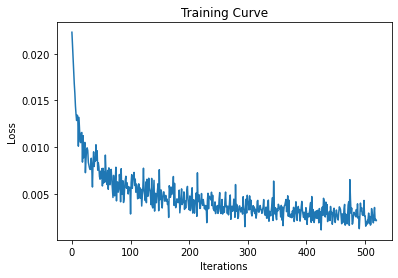

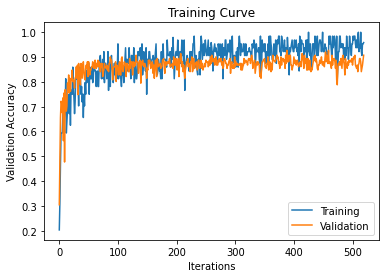

Final Training Accuracy: 0.9565637065637066
Final Validation Accuracy: 0.9072847682119205
Total time:   37.13 s  Time per Epoch:   4.64 s 


In [ ]:
def get_data_loader_normalize_proc(batch_size):
    train_path= "/content/gdrive/MyDrive/360 Project/ct_gamma_hist_aug/Train"
    val_path= "/content/gdrive/MyDrive/360 Project/ct_gamma_hist_aug/Validation"
    test_path= "/content/gdrive/MyDrive/360 Project/ct_gamma_hist_aug/Test"

    # set fix size
    transform = transforms.Compose(
            [transforms.Resize((224,224)), transforms.ToTensor(), 
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    train_data = torchvision.datasets.ImageFolder(root=train_path,transform=transform)
    val_data = torchvision.datasets.ImageFolder(root=val_path,transform=transform)
    test_data = torchvision.datasets.ImageFolder(root=test_path,transform=transform)
    train_sub = list(range(0, len(train_data), 3))
    val_sub = list(range(0, len(val_data), 10))
    test_sub = list(range(0, len(test_data), 10))
    train_set = torch.utils.data.Subset(train_data, train_sub)
    val_set = torch.utils.data.Subset(val_data, val_sub)
    test_set = torch.utils.data.Subset(test_data, test_sub)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                            num_workers=1, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, 
                                            num_workers=1, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, 
                                            num_workers=1, shuffle=True)

    classes = ['Viral', 'Normal', 'Covid', 'Bacterial']
    return train_loader, val_loader, test_loader, classes

batch_size = 64
train_data_loader_proc, val_data_loader_proc, test_data_loader_proc, classes = get_data_loader_normalize_proc(batch_size)

train_features_vgg_proc_all, val_features_vgg_proc_all, test_features_vgg_proc_all = vgg_net_proc_all(batch_size,
                                                                                                      train_data_loader_proc, val_data_loader_proc, test_data_loader_proc)
vgg_model_classifier_var1_proc_all = vgg_CNN_classifier_var1()
#proper model
train_vgg_classifier_var2(vgg_model_classifier_var1_proc_all, train_features_vgg_proc_all, val_features_vgg_proc_all, batch_size=64, num_epochs=8,wd=0.06)

model_save_name1 = "test_proc_1_third"
path1 = F"/content/gdrive/My Drive/360 Project/{model_save_name1}"
torch.save(vgg_model_classifier_var1_proc_all.state_dict(), path1)

In [ ]:
# path1 = F"/content/gdrive/MyDrive/360 Project/test_proc_1_third"
path1 = F"/content/gdrive/MyDrive/360 Project/model_vgg_CNN_var1_bs64_training_Methodvar2_wd0.06.pt"
model1 = vgg_CNN_classifier_var1()
model1.load_state_dict(torch.load(path1))

<All keys matched successfully>

#**Confusion Matrix Test**

In [ ]:
# dataset
val_path= "/content/gdrive/My Drive/360 Project/ct_gamma_hist/Validation"
#val_path= "/content/gdrive/My Drive/360 Project/new_test_data1"
test_path= "/content/gdrive/My Drive/360 Project/ct_gamma_hist/Test"
#test_path= "/content/gdrive/My Drive/360 Project/new_test_data1"

# set fix size
transform = transforms.Compose(
        [transforms.Resize((224,224)), transforms.ToTensor(), 
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

val_data = torchvision.datasets.ImageFolder(root=val_path,transform=transform)
test_data = torchvision.datasets.ImageFolder(root=test_path,transform=transform)

val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, 
                                        num_workers=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, 
                                        num_workers=1, shuffle=True)

val_features = []
for i, data in enumerate(val_loader, 0):
    images, labels = data
    val_features.append((torch.from_numpy(vgg.features(images).detach().numpy()), labels))
    print ("Extracting val_feature of the %d batch Finished. " % i)
test_features = []
for i, data in enumerate(test_loader, 0):
    images, labels = data
    test_features.append((torch.from_numpy(vgg.features(images).detach().numpy()), labels))
    print ("Extracting test_feature of the %d batch Finished. " % i)

Extracting val_feature of the 0 batch Finished. 
Extracting val_feature of the 1 batch Finished. 
Extracting val_feature of the 2 batch Finished. 
Extracting val_feature of the 3 batch Finished. 
Extracting val_feature of the 4 batch Finished. 
Extracting val_feature of the 5 batch Finished. 
Extracting val_feature of the 6 batch Finished. 
Extracting val_feature of the 7 batch Finished. 
Extracting val_feature of the 8 batch Finished. 
Extracting val_feature of the 9 batch Finished. 
Extracting val_feature of the 10 batch Finished. 
Extracting val_feature of the 11 batch Finished. 
Extracting val_feature of the 12 batch Finished. 
Extracting val_feature of the 13 batch Finished. 
Extracting val_feature of the 14 batch Finished. 
Extracting val_feature of the 15 batch Finished. 
Extracting val_feature of the 16 batch Finished. 
Extracting val_feature of the 17 batch Finished. 
Extracting val_feature of the 18 batch Finished. 
Extracting val_feature of the 19 batch Finished. 
Extracting

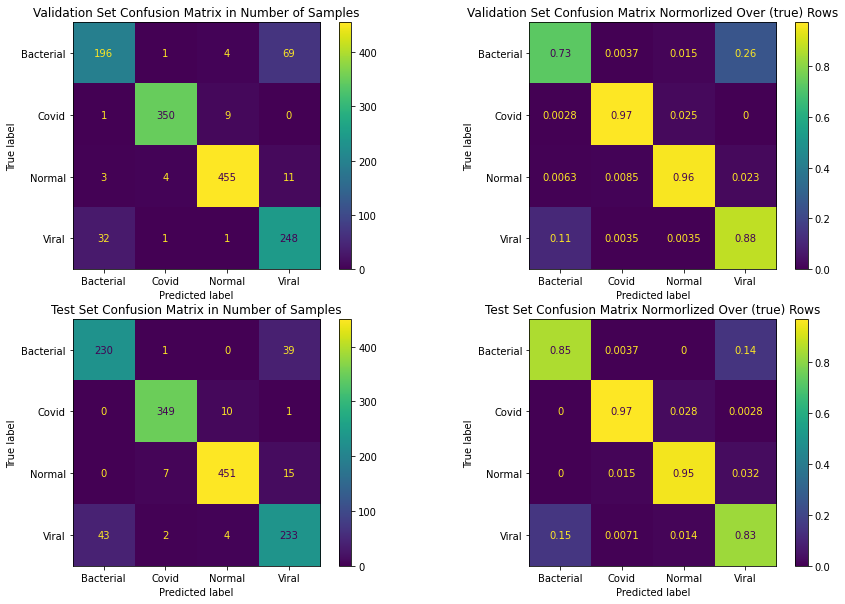

In [ ]:
from sklearn import metrics
# model path
path = "/content/gdrive/MyDrive/360 Project/model_vgg_CNN_var1_bs64_training_Methodvar2_wd0.06.pt"

# path model
net = vgg_CNN_classifier_var1()
state = torch.load(path)
net.load_state_dict(state)

# confusion matrix of val set
output = net(val_features[0][0])
pred = output.max(1, keepdim=True)[1]
true = val_features[0][1]
for i in range(len(val_features)-1):
    output = net(val_features[i+1][0])
    pred = torch.cat((pred,output.max(1, keepdim=True)[1]),0)
    true = torch.cat((true,val_features[i+1][1]))

classes = ['Bacterial', 'Covid', 'Normal', 'Viral']   

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
ax = axes.flatten()

cm = metrics.confusion_matrix(y_true=true, y_pred=pred, normalize=None)
disp= metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(ax=ax[0], values_format='d')
disp.ax_.set_title("Validation Set Confusion Matrix in Number of Samples")
cm = metrics.confusion_matrix(y_true=true, y_pred=pred, normalize='true')
disp= metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(ax=ax[1])
disp.ax_.set_title("Validation Set Confusion Matrix Normorlized Over (true) Rows")

# confusiong matrix of test set
output = net(test_features[0][0])
pred = output.max(1, keepdim=True)[1]
true = test_features[0][1]
for i in range(len(test_features)-1):
    output = net(test_features[i+1][0])
    pred = torch.cat((pred,output.max(1, keepdim=True)[1]),0)
    true = torch.cat((true,test_features[i+1][1]))

cm = metrics.confusion_matrix(y_true=true, y_pred=pred, normalize=None)
disp= metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(ax=ax[2], values_format='d')
disp.ax_.set_title("Test Set Confusion Matrix in Number of Samples")
cm = metrics.confusion_matrix(y_true=true, y_pred=pred, normalize='true')
disp= metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(ax=ax[3])
disp.ax_.set_title("Test Set Confusion Matrix Normorlized Over (true) Rows")

plt.show()

In [ ]:
# dataset
#val_path= "/content/gdrive/My Drive/360 Project/ct_gamma_hist/Validation"
val_path= "/content/gdrive/My Drive/360 Project/new_test_data1"
#test_path= "/content/gdrive/My Drive/360 Project/ct_gamma_hist/Test"
test_path= "/content/gdrive/My Drive/360 Project/new_test_data1"

# set fix size
transform = transforms.Compose(
        [transforms.Resize((224,224)), transforms.ToTensor(), 
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

val_data = torchvision.datasets.ImageFolder(root=val_path,transform=transform)
test_data = torchvision.datasets.ImageFolder(root=test_path,transform=transform)

val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, 
                                        num_workers=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, 
                                        num_workers=1, shuffle=True)

val_features = []
for i, data in enumerate(val_loader, 0):
    images, labels = data
    val_features.append((torch.from_numpy(vgg.features(images).detach().numpy()), labels))
    print ("Extracting val_feature of the %d batch Finished. " % i)
test_features = []
for i, data in enumerate(test_loader, 0):
    images, labels = data
    test_features.append((torch.from_numpy(vgg.features(images).detach().numpy()), labels))
    print ("Extracting test_feature of the %d batch Finished. " % i)

Extracting val_feature of the 0 batch Finished. 
Extracting val_feature of the 1 batch Finished. 
Extracting val_feature of the 2 batch Finished. 
Extracting val_feature of the 3 batch Finished. 
Extracting val_feature of the 4 batch Finished. 
Extracting val_feature of the 5 batch Finished. 
Extracting val_feature of the 6 batch Finished. 
Extracting val_feature of the 7 batch Finished. 
Extracting val_feature of the 8 batch Finished. 
Extracting test_feature of the 0 batch Finished. 
Extracting test_feature of the 1 batch Finished. 
Extracting test_feature of the 2 batch Finished. 
Extracting test_feature of the 3 batch Finished. 
Extracting test_feature of the 4 batch Finished. 
Extracting test_feature of the 5 batch Finished. 
Extracting test_feature of the 6 batch Finished. 
Extracting test_feature of the 7 batch Finished. 
Extracting test_feature of the 8 batch Finished. 


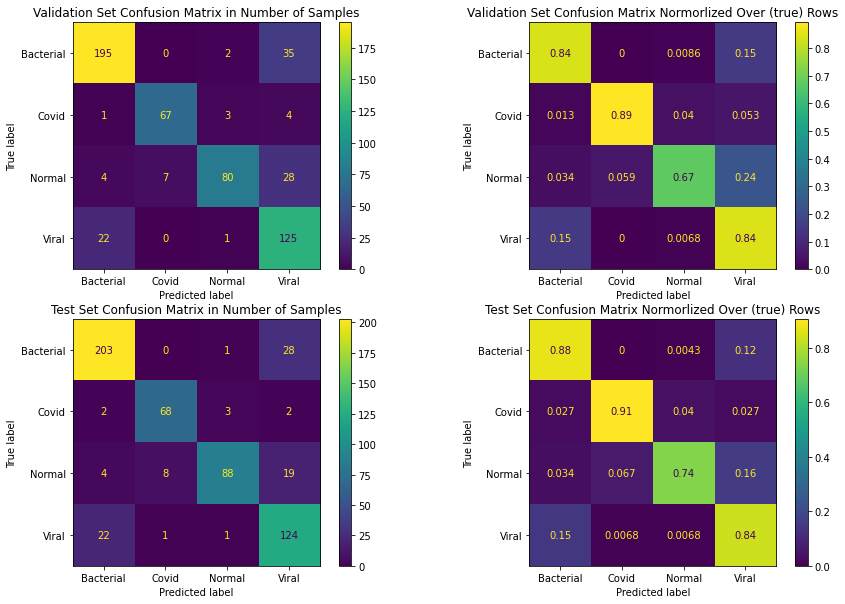

In [ ]:
from sklearn import metrics
# model path
path = "/content/gdrive/MyDrive/360 Project/model_vgg_CNN_var1_bs64_training_Methodvar2_wd0.06.pt"

# path model
net = vgg_CNN_classifier_var1()
state = torch.load(path)
net.load_state_dict(state)

# confusion matrix of val set
output = net(val_features[0][0])
pred = output.max(1, keepdim=True)[1]
true = val_features[0][1]
for i in range(len(val_features)-1):
    output = net(val_features[i+1][0])
    pred = torch.cat((pred,output.max(1, keepdim=True)[1]),0)
    true = torch.cat((true,val_features[i+1][1]))

classes = ['Bacterial', 'Covid', 'Normal', 'Viral']   

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
ax = axes.flatten()

cm = metrics.confusion_matrix(y_true=true, y_pred=pred, normalize=None)
disp= metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(ax=ax[0], values_format='d')
disp.ax_.set_title("Validation Set Confusion Matrix in Number of Samples")
cm = metrics.confusion_matrix(y_true=true, y_pred=pred, normalize='true')
disp= metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(ax=ax[1])
disp.ax_.set_title("Validation Set Confusion Matrix Normorlized Over (true) Rows")

# confusiong matrix of test set
output = net(test_features[0][0])
pred = output.max(1, keepdim=True)[1]
true = test_features[0][1]
for i in range(len(test_features)-1):
    output = net(test_features[i+1][0])
    pred = torch.cat((pred,output.max(1, keepdim=True)[1]),0)
    true = torch.cat((true,test_features[i+1][1]))

cm = metrics.confusion_matrix(y_true=true, y_pred=pred, normalize=None)
disp= metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(ax=ax[2], values_format='d')
disp.ax_.set_title("Test Set Confusion Matrix in Number of Samples")
cm = metrics.confusion_matrix(y_true=true, y_pred=pred, normalize='true')
disp= metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(ax=ax[3])
disp.ax_.set_title("Test Set Confusion Matrix Normorlized Over (true) Rows")

plt.show()